### Lab 3. Gradient descent methods

1. Implement:

    (a) Constant-step gradient descent;
    
    (b) Gradient descent with fractional steps (Armijo condition);
    
    (c) Steepest descent (using any two one-dimensional search methods);
    
    (d) Conjugate gradient method (with restart).
2. For the study, consider:

    (a) Well-conditioned (μ ≃1) two-dimensional quadratic function;
   
    (b) Ill-conditioned (μ > 10) two-dimensional quadratic function;
   
    (c) Rosenbrock function.
3. For each function:

    (a) Build a table that reflects the dependence of the number of iterations of the gradient method, the number of function calculations(if any), and the number of function gradient calculations (if any) for each of the methods on the chosen accuracy;
   
    (b) plot the data from the table (abscissa axis – accuracy, ordinate axis – number of iterations/function/gradient calculations);
4. For the Rosenbrock function, plot and compare the trajectories of each method on the level line plot.

5. Implement a generator of quadratic functions of a given dimension and condition number. Investigate the dependence of the number of iterations that must be performed to achieve the selected accuracy, depending on these parameters. Consider this dependence for two gradient methods, one of which is (necessarily) the conjugate gradient method.

#### 1

Implement:

(a) Constant-step gradient descent;

(b) Gradient descent with fractional steps (Armijo condition);

(c) Steepest descent (using any two one-dimensional search methods);

(d) Conjugate gradient method (with restart).

In [334]:
import numpy as np
import pandas as pd
import numba as nb
import matplotlib.pyplot as plt
import warnings
from IPython.display import Markdown
from typing import Callable

In [335]:
def grad(
    f: Callable[[np.ndarray], float],
    x: np.ndarray,
):
    Delta_f = np.zeros_like(x, dtype=float)
    for k in range(len(x)):
        dx = np.zeros_like(x, dtype=float)
        dx[k] = np.finfo(float).eps * 10
        # print(f(x + dx))
        Delta_f[k] = (f(x + dx) - f(x - dx)) / (2 * np.linalg.norm(dx))
    return Delta_f

In [336]:
# a
def gd_constant_step(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    lr: float = 0.01,
    maxit: int = 1000,
    eps: float = 1e-9,
    info=False,
) -> np.ndarray:
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x)<eps:
            break
        
        trajectory.append(x.copy())
        iters += 1
        grad_calls += 1
        
        x -= lr * grad(f, x)
        
    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x

In [337]:
# b
def gd_fractional_step(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    lr: float = 0.01,
    maxit: int = 1000,
    gamma: float = np.finfo(float).eps * 10,
    eps: float = np.finfo(float).eps * 10,
    lamb=0.5,
    info: bool = False,
) -> np.ndarray:
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x)<eps:
            break
        
        iters += 1
        calls += 2
        grad_calls += 1
        trajectory.append(x.copy())

        g = grad(f, x)
        if f(x) - f(x - lr * g) > gamma * lr * np.linalg.norm(g) ** 2:
            x -= lr * g
        else:
            lr *= lamb
            x -= lr * g

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x

In [338]:
def brent_search(
    f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False
):
    iter_count, f_call_count = 1, 1
    if b < a:
        a, b = b, a
    K = (3 - 5**0.5) / 2
    x = w = v = (a + b) / 2
    fw = fv = fx = f(x)
    deltax = 0.0
    iter = 0
    maxiter = 1e9
    while iter < maxiter:
        iter += 1
        iter_count += 1

        mintol = eps / 4
        tol1 = eps * np.abs(x) + mintol
        tol2 = 2.0 * tol1
        xmid = 0.5 * (a + b)
        # check for convergence
        if np.abs(x - xmid) < (tol2 - 0.5 * (b - a)):
            break
        if np.abs(deltax) <= tol1:
            if x >= xmid:
                deltax = a - x  # do a golden section step
            else:
                deltax = b - x
            rat = K * deltax
        else:  # do a parabolic step
            tmp1 = (x - w) * (fx - fv)
            tmp2 = (x - v) * (fx - fw)
            p = (x - v) * tmp2 - (x - w) * tmp1
            tmp2 = 2.0 * (tmp2 - tmp1)
            if tmp2 > 0.0:
                p = -p
            tmp2 = np.abs(tmp2)
            dx_temp = deltax
            deltax = rat
            # determine whether a parabolic step is acceptable or not:
            if (
                (p > tmp2 * (a - x))
                and (p < tmp2 * (b - x))
                and (np.abs(p) < np.abs(0.5 * tmp2 * dx_temp))
            ):
                # whew, parabolic fit:
                rat = p * 1.0 / tmp2
                u = x + rat
                if (u - a) < tol2 or (b - u) < tol2:
                    if xmid - x >= 0:
                        rat = tol1
                    else:
                        rat = -tol1
            else:
                # nope, try golden section instead
                if x >= xmid:
                    deltax = a - x
                else:
                    deltax = b - x
                rat = K * deltax
        # update current position:
        if np.abs(rat) < tol1:  # update by at least tol1
            if rat >= 0:
                u = x + tol1
            else:
                u = x - tol1
        else:
            u = x + rat
        fu = f(u)
        f_call_count += 1
        if fu > fx:
            # Oh dear, point u is worse than what we have already,
            # even so it *must* be better than one of our endpoints:
            if u < x:
                a = u
            else:
                b = u

            if (fu <= fw) or (w == x):
                # however it is at least second best:
                v = w
                w = u
                fv = fw
                fw = fu
            elif (fu <= fv) or (v == x) or (v == w):
                # third best:
                v = u
                fv = fu
        else:
            # good new point is an improvement!
            # update brackets:
            if u >= x:
                a = x
            else:
                b = x
            # update control points:
            v = w
            w = x
            x = u
            fv = fw
            fw = fx
            fx = fu
    res = x
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [339]:
def golden_section_search(
    f: Callable[[float], float], a: float, b: float, eps=1e-9, info=False
):
    iter_count, f_call_count = 0, 0
    if b < a:
        a, b = b, a
    # golden ratio
    gr = (5**0.5 - 1) / 2

    iter_count += 1
    f_call_count += 2
    x = b - (b - a) * gr
    y = a + (b - a) * gr
    fx = f(x)
    fy = f(y)
    while b - a > eps:
        iter_count += 1
        f_call_count += 1
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * gr
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * gr
            fy = f(y)

    res = (b + a) / 2
    if not info:
        return res
    else:
        return res, iter_count, f_call_count, b - a


In [340]:
# c
def steepest_descent(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float=0.1,
    method: str = "golden_section",
    maxit: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    info: bool = False,
) -> np.ndarray:
    """golden_section search or brent_search"""
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(maxit):
        if np.linalg.norm(x)<eps:
            break
        
        iters += 1
        grad_calls += 1
        trajectory.append(x.copy())

        g = grad(f, x)
        lr, iter_count, f_call_count, unsertainty = search_method(
            lambda y: f(x - y * g), 0, max_lr, eps=eps, info=True
        )
        calls += f_call_count

        x -= lr * g

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x

In [341]:
# d
def conjugate_gradient(
    f: Callable[[np.ndarray], np.ndarray],
    x0: np.ndarray,
    max_lr: float=0.1,
    method: str = "golden_section",
    max_it: int = 1000,
    eps: float = np.finfo(float).eps * 10,
    max_subit: int = None,
    info: bool = False,
) -> np.ndarray:
    """golden_section search or brent_search"""
    iters = 0
    calls = 0
    grad_calls = 0
    trajectory = []

    if max_subit is None:
        max_subit = len(x0)
    if method == "golden_section":
        search_method = golden_section_search
    else:
        search_method = brent_search
    x = x0
    for _ in range(max_it):
        if np.linalg.norm(x)<eps:
            break
        grad_calls += 1
        g = grad(f, x)
        r0 = -g
        d = r0
        for k in range(max_subit):
            if np.linalg.norm(x)<eps:
                break
            
            lr, iter_count, f_call_count, unsertainty = search_method(
                lambda y: f(x + y * d), 0, max_lr, eps=eps, info=True
            )
            iters += 1
            calls += f_call_count
            grad_calls += 1
            trajectory.append(x.copy())

            x += lr * d
            r1 = -grad(f, x)
            # Polak-Ribiere
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                beta = r1.T @ (r1 - r0) / (r0.T @ r0)
            if np.isnan(beta):
                beta=0.
            beta = max(beta, 0.)
            d = r1 + beta * d
            r0 = r1

    trajectory.append(x.copy())
    if info:
        return x, iters, calls, grad_calls, trajectory
    else:
        return x

In [342]:
def test_gd_simple():
    def f1(x):
        return np.linalg.norm(x) ** 2

    print(gd_constant_step(f1, np.random.random(1), 0.1))
    assert np.isclose(gd_constant_step(f1, np.random.random(1), 0.1), 0)
    print(gd_fractional_step(f1, np.random.random(1), 0.1))
    assert np.isclose(gd_fractional_step(f1, np.random.random(1), 0.1), 0)
    print(steepest_descent(f1, np.random.random(1), 0.1))
    assert np.isclose(steepest_descent(f1, np.random.random(1), 0.1), 0)
    print(conjugate_gradient(f1, np.random.random(1), 0.1))
    assert np.isclose(conjugate_gradient(f1, np.random.random(1), 0.1), 0)


test_gd_simple()

[9.46315313e-10]
[2.0556739e-15]
[1.96215902e-15]
[1.97018103e-15]


#### 2
For the study, consider:

(a) Well-conditioned (μ ≃1) two-dimensional quadratic function;
   
(b) Ill-conditioned (μ > 10) two-dimensional quadratic function;
   
(c) Rosenbrock function.

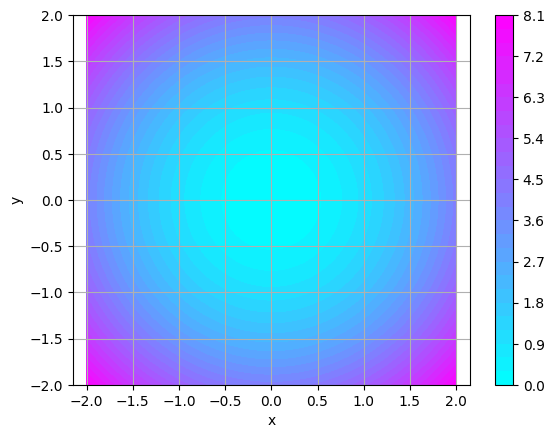

In [343]:
# a
@nb.njit
def f_a(x: np.ndarray) -> np.ndarray:
    assert len(x.shape) == 1
    assert x.shape[0] == 2
    mu = 1
    w = np.sqrt(mu)
    D = np.diag(np.array([1., 1.]))
    C = np.array([[5., 3.], [4., 2.]])
    Q, R = np.linalg.qr(C)
    G = Q.T @ D @ Q
    B = G.T @ G
    A = (B.T + B) / 2
    # print(np.linalg.cond(A), mu, w)
    # print(A, D)
    assert np.isclose(np.linalg.cond(A), mu)
    return (x.T @ A @ x)


def test_f_a():
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    # cond_num = z.copy()
    # grad_norm = z.copy()
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            p = np.array([xp, yp])
            z[qy, qx] = f_a(p)
            # cond_num[qy, qx] = np.linalg.norm(p)/np.linalg.norm(f_a(p))*np.linalg.norm(grad(f_a, p))
            # grad_norm[qy, qx] = np.linalg.norm(grad(f_a, p))

    plt.contourf(x, y, z, levels=30,cmap='cool')
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()
    # plt.contourf(x, y, cond_num, levels=30)
    # plt.grid()
    # plt.axis("equal")
    # plt.xlabel("x")
    # plt.ylabel("y")
    # plt.colorbar()
    # plt.show()

    # plt.contourf(x, y, grad_norm, levels=30)
    # plt.grid()
    # plt.axis("equal")
    # plt.xlabel("x")
    # plt.ylabel("y")
    # plt.colorbar()
    # plt.show()


test_f_a()

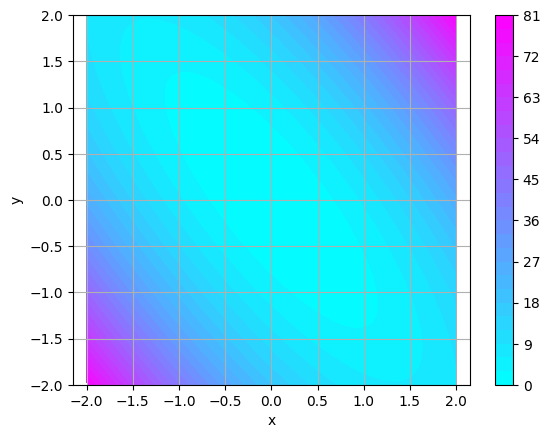

In [344]:
# b
@nb.njit
def f_b(x: np.ndarray) -> np.ndarray:
    assert len(x.shape) == 1
    assert x.shape[0] == 2

    mu = 10.
    w = np.sqrt(mu)
    D = np.diag(np.array([w, 1.]))
    C = np.array([[5., 3.], [4., 2.]])
    Q, R = np.linalg.qr(C)
    G = Q.T @ D @ Q
    B = G.T @ G
    A = (B.T + B) / 2
    # print(np.linalg.cond(A), mu, w)
    # print(A, D)
    assert np.isclose(np.linalg.cond(A), mu)
    return (x.T @ A @ x)


def test_f_b():
    x = np.linspace(-2, 2, 50)
    y = np.linspace(-2, 2, 50)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            p = np.array([xp, yp])
            z[qy, qx] = f_b(p)

    plt.contourf(x, y, z, levels=30,cmap='cool')
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()


test_f_b()

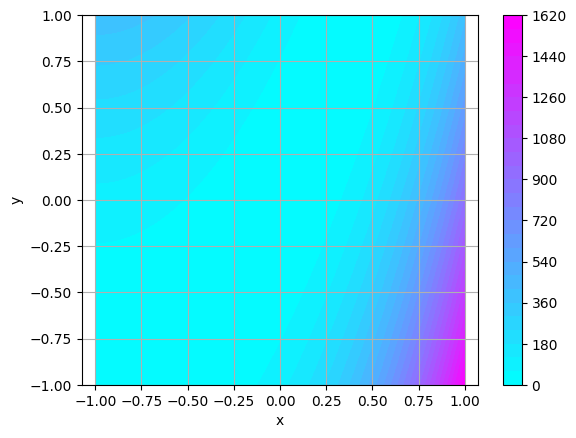

In [362]:
# c
@nb.njit
def f_c(x: np.ndarray) -> np.ndarray:
    # rosenbrock - shifted so that minimum at (0,0)
    # a:float=1.
    # b:float=100.
    # assert len(x.shape) == 1
    # assert x.shape[0] == 2
    # yp = x[1]+a**2
    # xp = x[0]+a
    # return (a - xp) ** 2 + b * (yp - xp ** 2) ** 2
    return (x[0]) ** 2 + 100. * ((x[1]+1.) - (x[0]+1.) ** 2) ** 2

def test_f_c():
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    xr, yr = np.meshgrid(x, y)
    z = 0 * xr * yr
    for qx, xp in enumerate(x):
        for qy, yp in enumerate(y):
            p = np.array([xp, yp])
            z[qy, qx] = f_c(p)

    plt.contourf(x, y, z, levels=30,cmap='cool')
    plt.grid()
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()


test_f_c()

#### 3
For each function:

(a) Build a table that reflects the dependence of the number of iterations of the gradient method, the number of function calculations(if any), and the number of function gradient calculations (if any) for each of the methods on the chosen accuracy;
   
(b) plot the data from the table (abscissa axis – accuracy, ordinate axis – number of iterations/function/gradient calculations);


$\mu \approx 1$

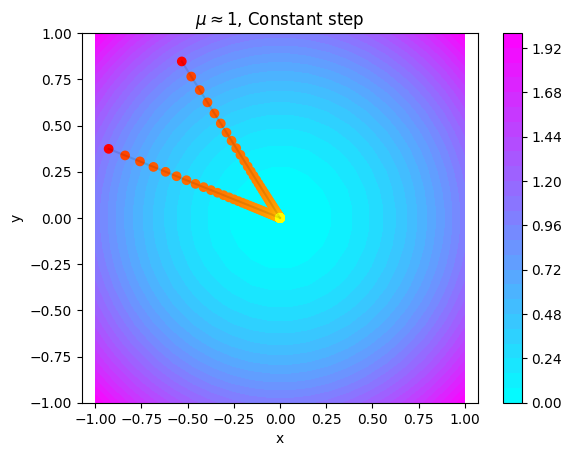

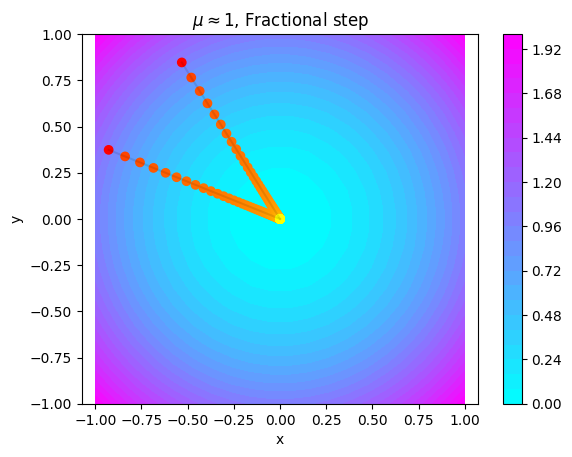

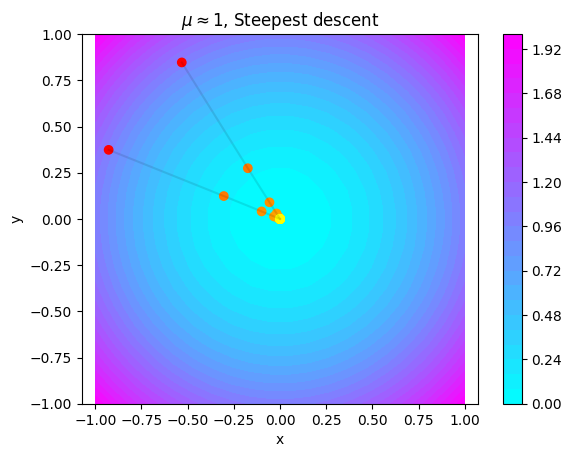

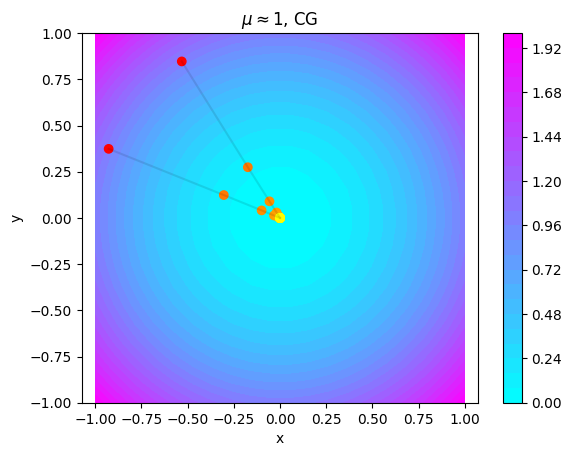

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01              9.900569e-02                    114   
1   3.359818e-02              3.325595e-02                    168   
2   1.128838e-02              1.128379e-02                    222   
3   3.792690e-03              3.790169e-03                    276   
4   1.274275e-03              1.273110e-03                    330   
5   4.281332e-04              4.276360e-04                    384   
6   1.438450e-04              1.436423e-04                    438   
7   4.832930e-05              4.824925e-05                    492   
8   1.623777e-05              1.620685e-05                    546   
9   5.455595e-06              5.443857e-06                    600   
10  1.832981e-06              1.828583e-06                    654   
11  6.158482e-07              6.142185e-07                    708   
12  2.069138e-07              2.063151e-07                    762   
13  6.951928e-08              6.930093e-08                    816   
14  2.335721e-08              2.327808e-08                    870   
15  7.847600e-09              7.819072e-09                    924   
16  2.636651e-09              2.626415e-09                    978   
17  8.858668e-10              1.683980e-09                   1000   
18  2.976351e-10              1.683980e-09                   1000   
19  1.000000e-10              1.683980e-09                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                    114                9.900569e-02   
1                       0                    168                3.325595e-02   
2                       0                    222                1.128379e-02   
3                       0                    276                3.790169e-03   
4                       0                    330                1.273110e-03   
5                       0                    384                4.276360e-04   
6                       0                    438                1.436423e-04   
7                       0                    492                4.824925e-05   
8                       0                    546                1.620685e-05   
9                       0                    600                5.443857e-06   
10                      0                    654                1.828583e-06   
11                      0                    708                6.142185e-07   
12                      0                    762                2.063151e-07   
13                      0                    816                6.930093e-08   
14                      0                    870                2.327808e-08   
15                      0                    924                7.819072e-09   
16                      0                    978                2.626415e-09   
17                      0                   1000                1.683980e-09   
18                      0                   1000                1.683980e-09   
19                      0                   1000                1.683980e-09   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                       114                      229                      114   
1                       168                      337                      168   
2                       222                      444                      222   
3                       276                      552                      276   
4                       330                      660                      330   
5                       384                      768                      384   
6                       438                      876                      438   
7                       492                      984                      492   
8                       546                     1092                      546   
9                       600                     1200                    

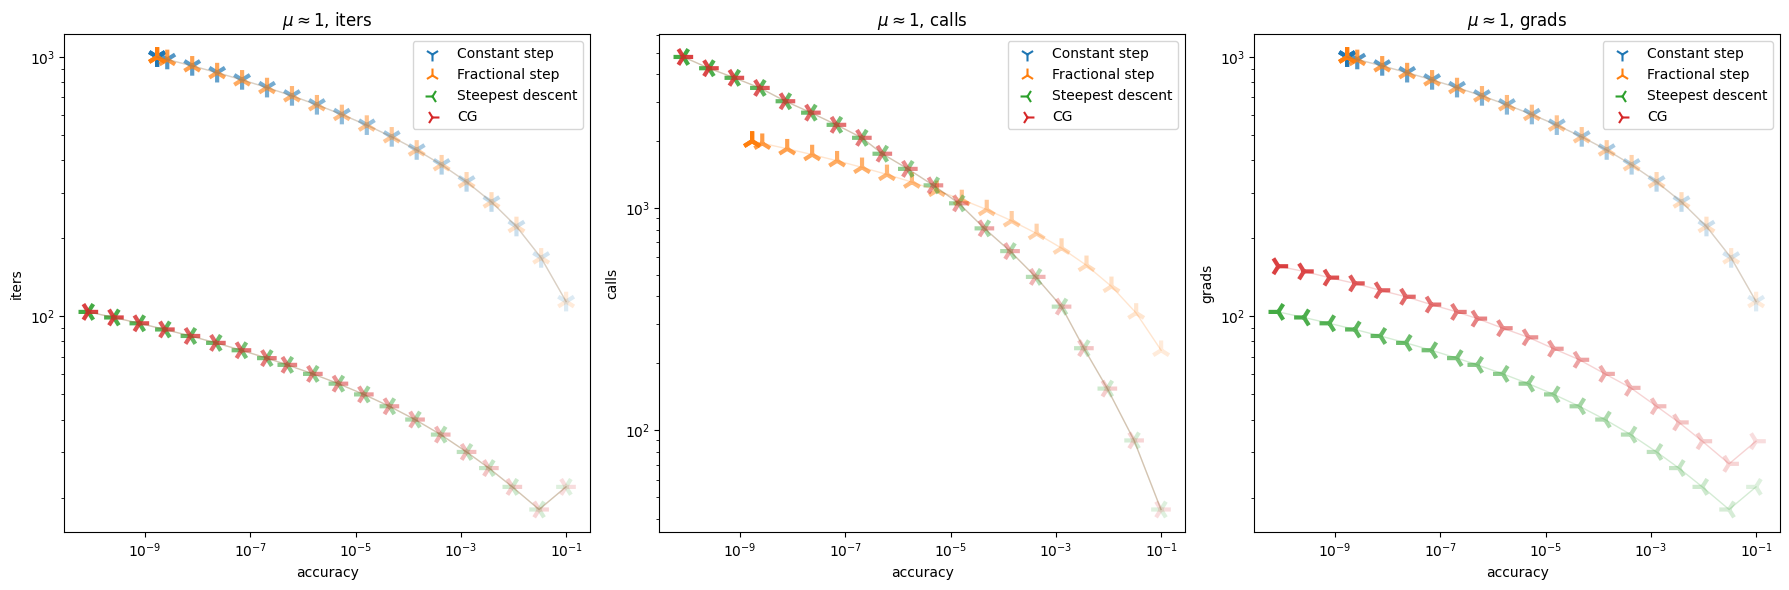

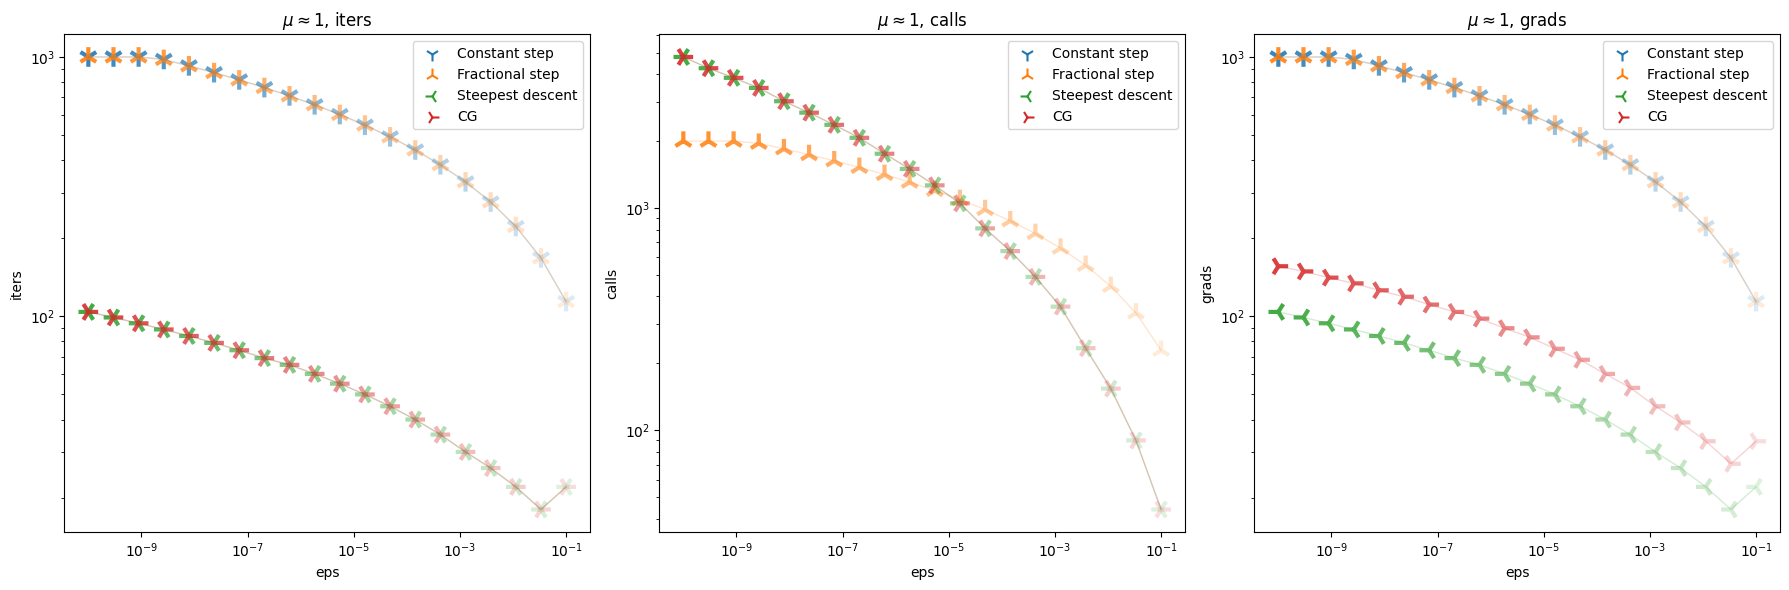

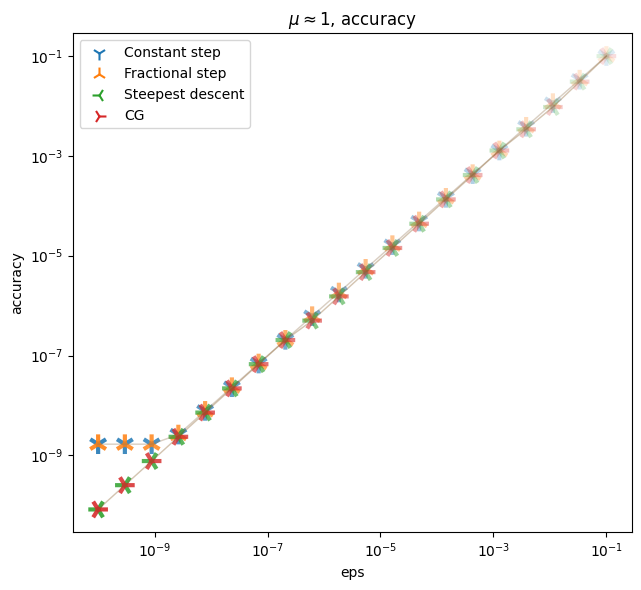

$\mu \approx 10$

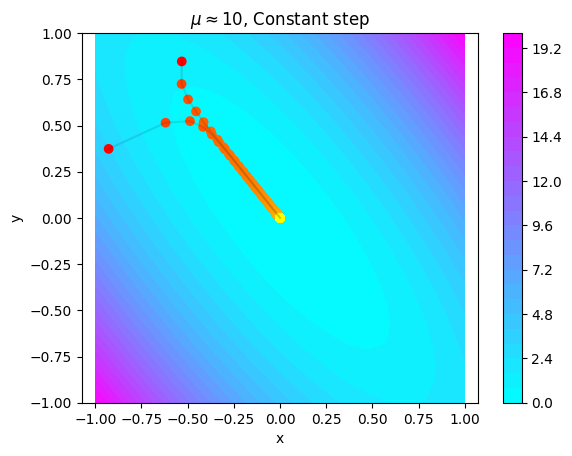

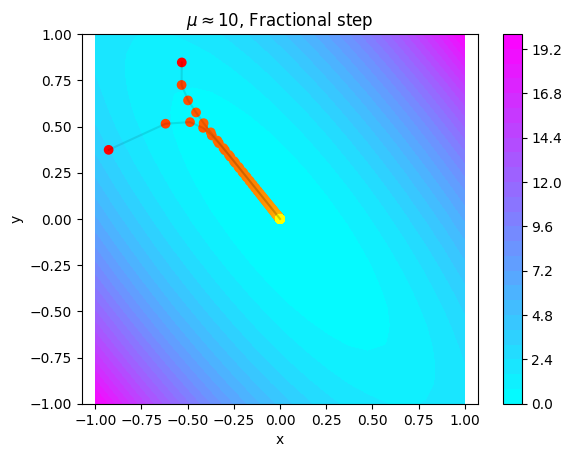

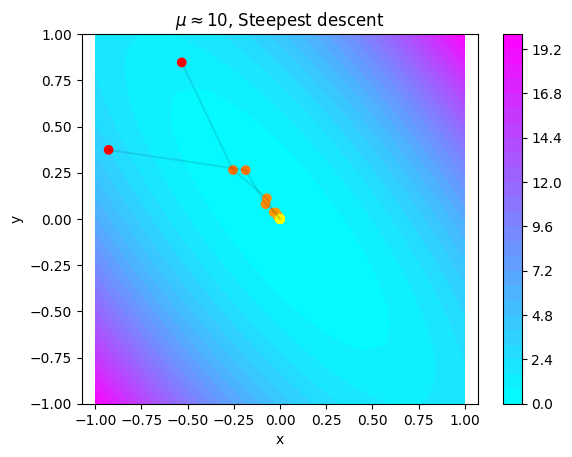

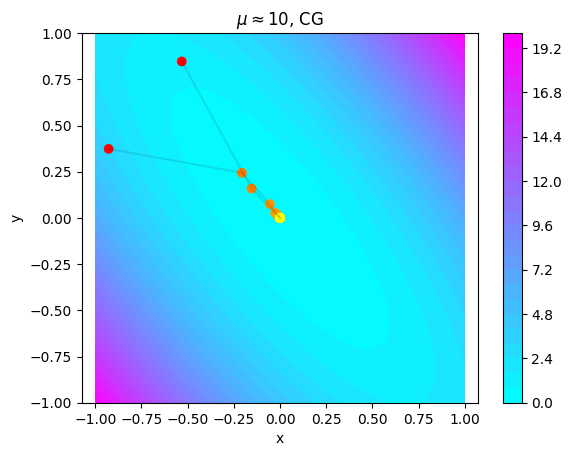

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01              9.879115e-02                    111   
1   3.359818e-02              3.318540e-02                    165   
2   1.128838e-02              1.114591e-02                    219   
3   3.792690e-03              3.743834e-03                    273   
4   1.274275e-03              1.257541e-03                    327   
5   4.281332e-04              4.224074e-04                    381   
6   1.438450e-04              1.418861e-04                    435   
7   4.832930e-05              4.765934e-05                    489   
8   1.623777e-05              1.600870e-05                    543   
9   5.455595e-06              5.377299e-06                    597   
10  1.832981e-06              1.806227e-06                    651   
11  6.158482e-07              6.067088e-07                    705   
12  2.069138e-07              2.037926e-07                    759   
13  6.951928e-08              6.845363e-08                    813   
14  2.335721e-08              2.299347e-08                    867   
15  7.847600e-09              7.723474e-09                    921   
16  2.636651e-09              2.594303e-09                    975   
17  8.858668e-10              1.568709e-09                   1000   
18  2.976351e-10              1.568709e-09                   1000   
19  1.000000e-10              1.568709e-09                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                    111                9.879115e-02   
1                       0                    165                3.318540e-02   
2                       0                    219                1.114591e-02   
3                       0                    273                3.743834e-03   
4                       0                    327                1.257541e-03   
5                       0                    381                4.224074e-04   
6                       0                    435                1.418861e-04   
7                       0                    489                4.765934e-05   
8                       0                    543                1.600870e-05   
9                       0                    597                5.377299e-06   
10                      0                    651                1.806227e-06   
11                      0                    705                6.067088e-07   
12                      0                    759                2.037926e-07   
13                      0                    813                6.845363e-08   
14                      0                    867                2.299347e-08   
15                      0                    921                7.723474e-09   
16                      0                    975                2.594303e-09   
17                      0                   1000                1.568709e-09   
18                      0                   1000                1.568709e-09   
19                      0                   1000                1.568709e-09   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                       111                      222                      111   
1                       165                      330                      165   
2                       219                      438                      219   
3                       273                      546                      273   
4                       327                      654                      327   
5                       381                      762                      381   
6                       435                      870                      435   
7                       489                      978                      489   
8                       543                     1086                      543   
9                       597                     1194                    

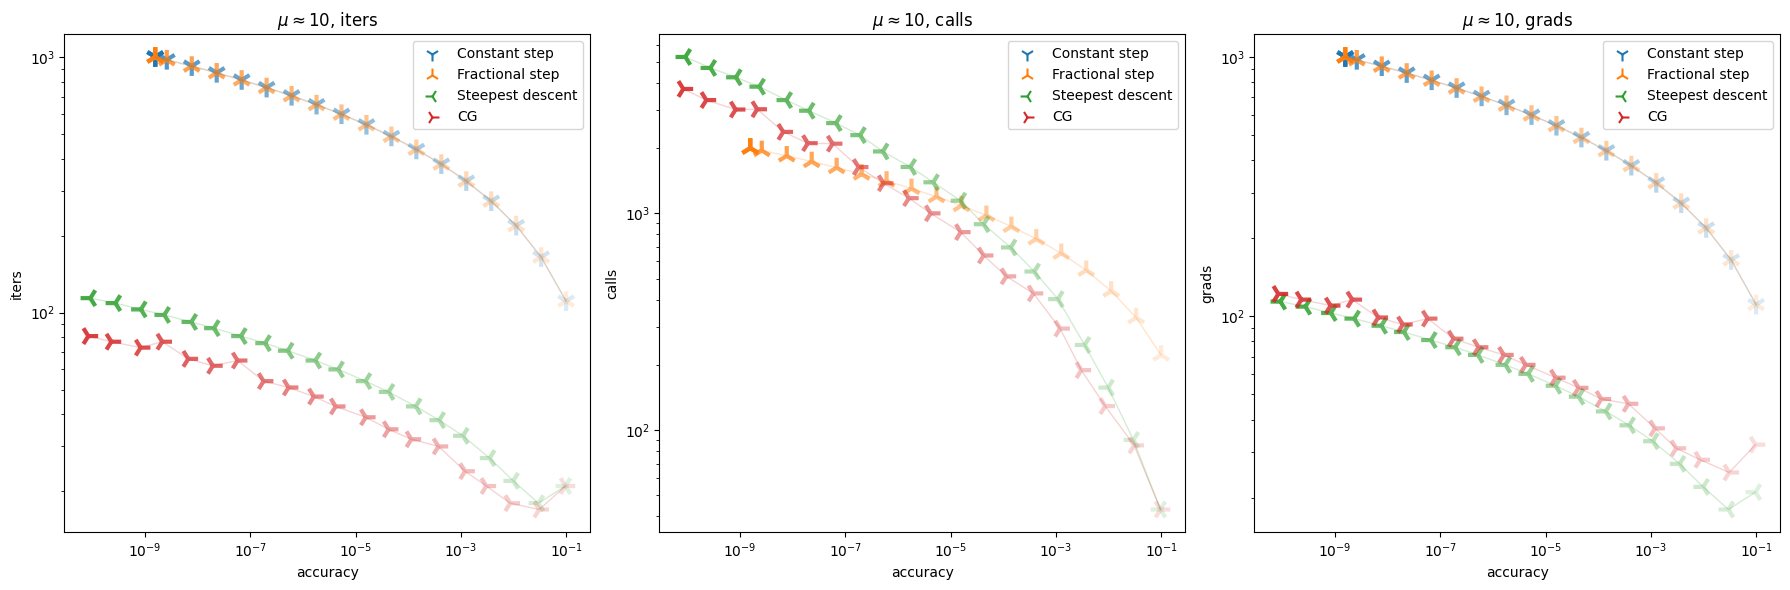

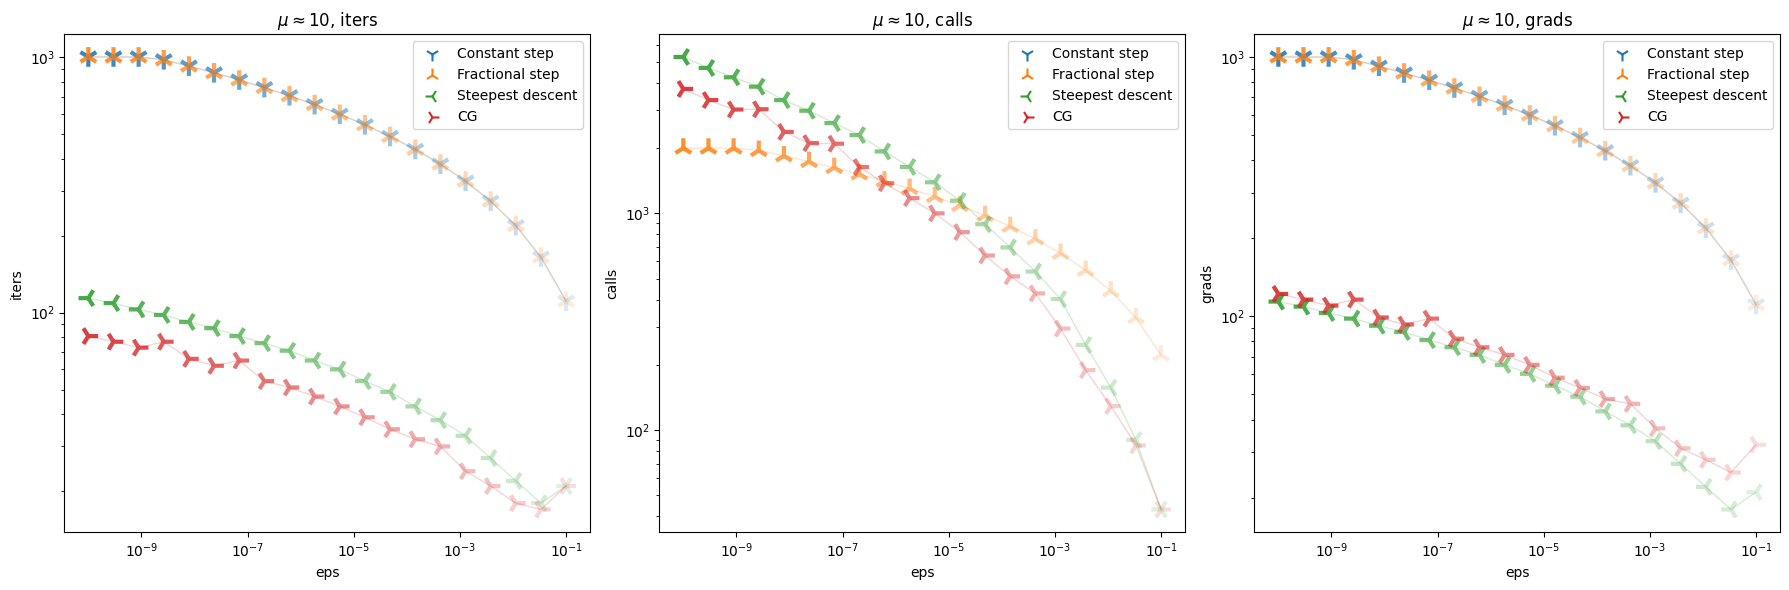

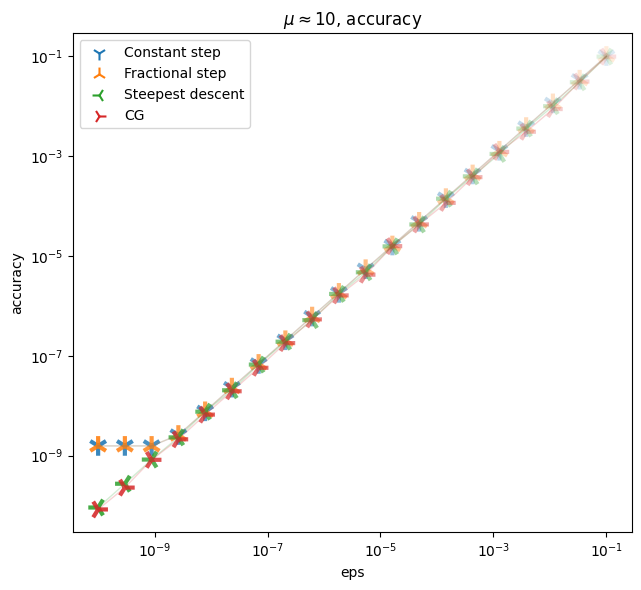

Rosenbrock

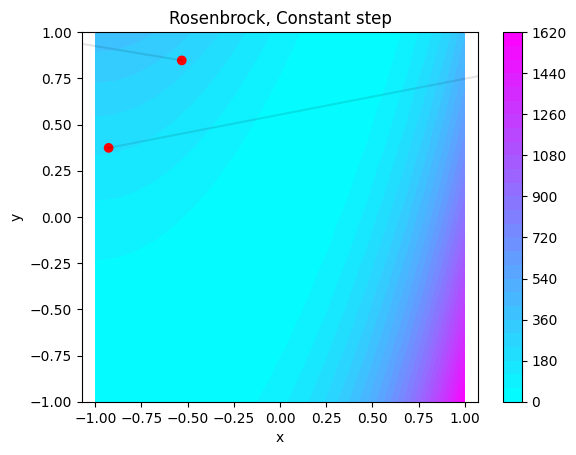

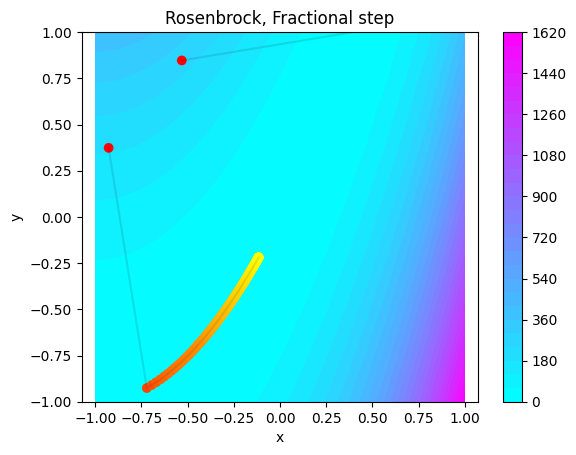

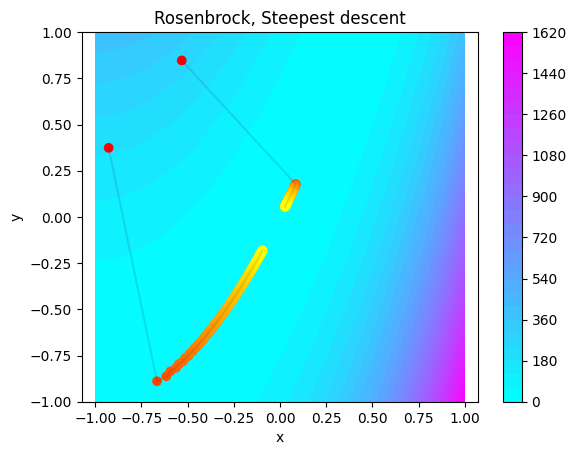

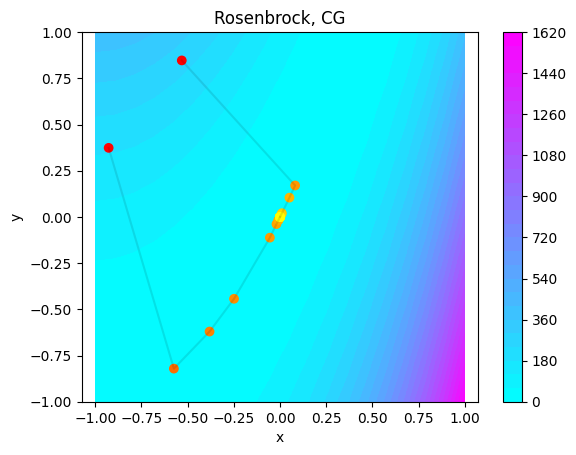

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01                128.853146                   1000   
1   3.359818e-02                128.853146                   1000   
2   1.128838e-02                128.853146                   1000   
3   3.792690e-03                128.853146                   1000   
4   1.274275e-03                128.853146                   1000   
5   4.281332e-04                128.853146                   1000   
6   1.438450e-04                128.853146                   1000   
7   4.832930e-05                128.853146                   1000   
8   1.623777e-05                128.853146                   1000   
9   5.455595e-06                128.853146                   1000   
10  1.832981e-06                128.853146                   1000   
11  6.158482e-07                128.853146                   1000   
12  2.069138e-07                128.853146                   1000   
13  6.951928e-08                128.853146                   1000   
14  2.335721e-08                128.853146                   1000   
15  7.847600e-09                128.853146                   1000   
16  2.636651e-09                128.853146                   1000   
17  8.858668e-10                128.853146                   1000   
18  2.976351e-10                128.853146                   1000   
19  1.000000e-10                128.853146                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                   1000                   25.880097   
1                       0                   1000                   25.880097   
2                       0                   1000                   25.880097   
3                       0                   1000                   25.880097   
4                       0                   1000                   25.880097   
5                       0                   1000                   25.880097   
6                       0                   1000                   25.880097   
7                       0                   1000                   25.880097   
8                       0                   1000                   25.880097   
9                       0                   1000                   25.880097   
10                      0                   1000                   25.880097   
11                      0                   1000                   25.880097   
12                      0                   1000                   25.880097   
13                      0                   1000                   25.880097   
14                      0                   1000                   25.880097   
15                      0                   1000                   25.880097   
16                      0                   1000                   25.880097   
17                      0                   1000                   25.880097   
18                      0                   1000                   25.880097   
19                      0                   1000                   25.880097   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                      1000                     2000                     1000   
1                      1000                     2000                     1000   
2                      1000                     2000                     1000   
3                      1000                     2000                     1000   
4                      1000                     2000                     1000   
5                      1000                     2000                     1000   
6                      1000                     2000                     1000   
7                      1000                     2000                     1000   
8                      1000                     2000                     1000   
9                      1000                     2000                    

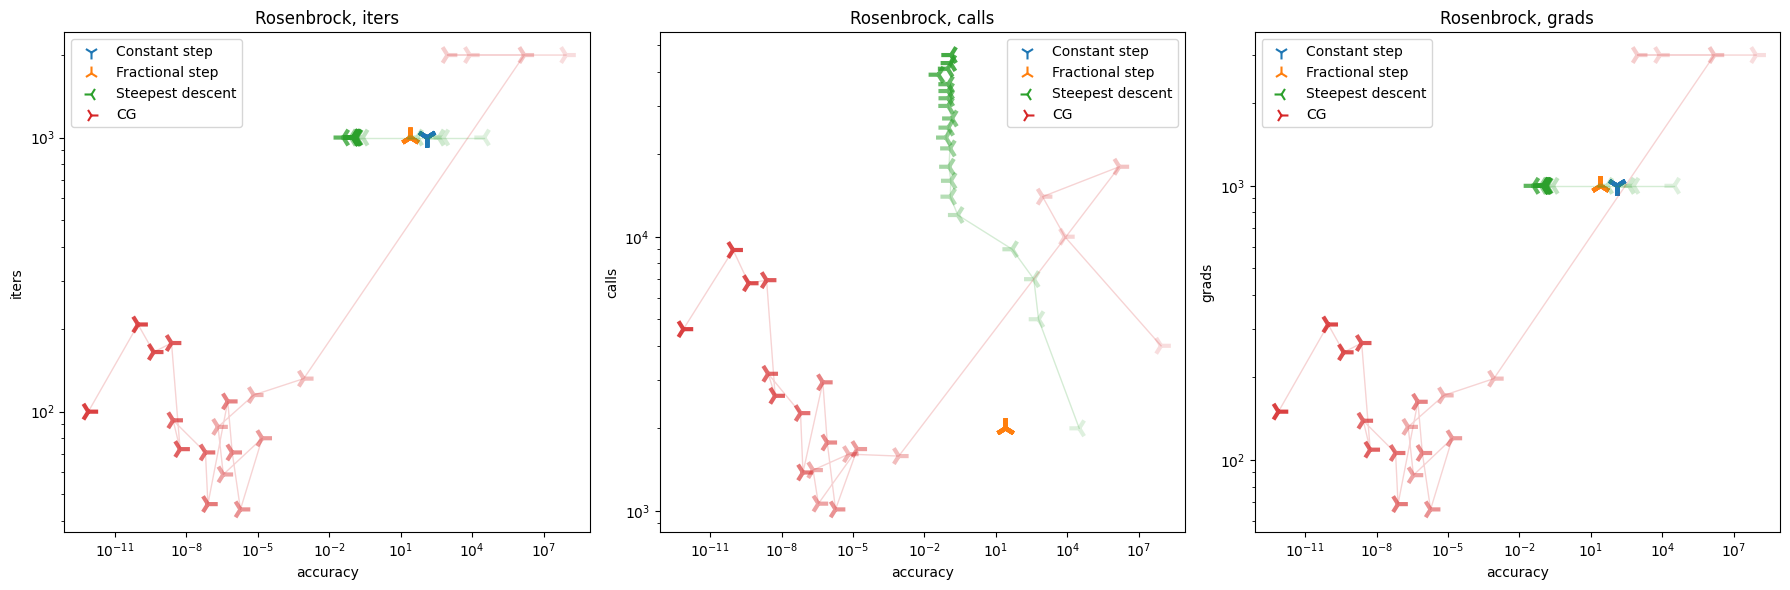

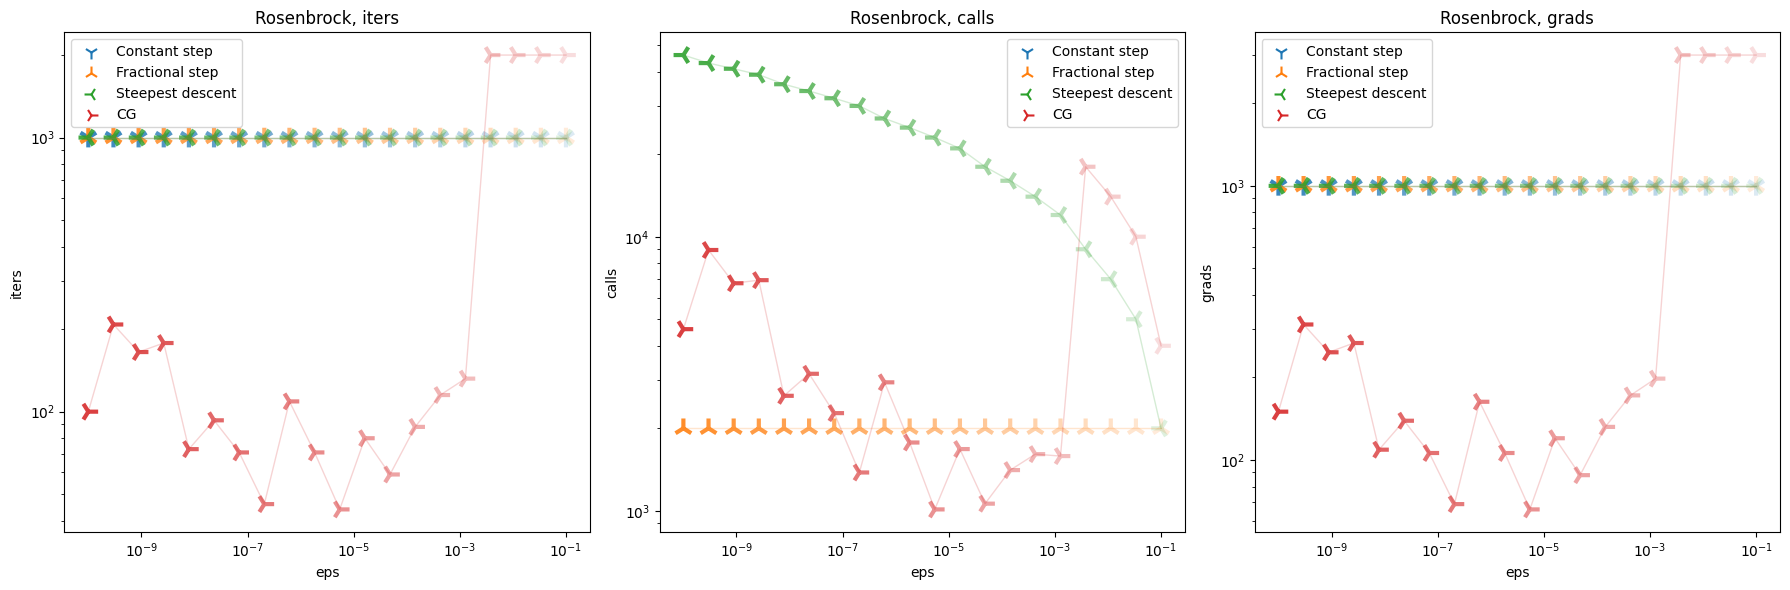

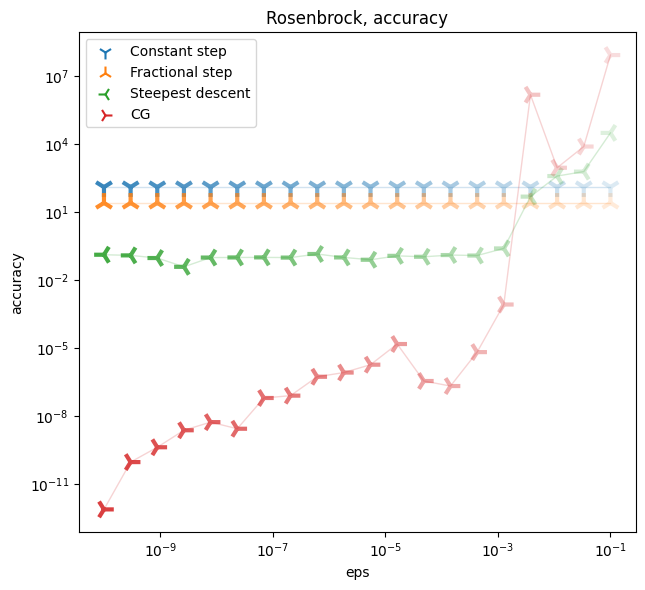

In [363]:
# a, b
functions = [
    (f_a, r"$\mu \approx 1$"),
    (f_b, r"$\mu \approx 10$"),
    (f_c, "Rosenbrock"),
]
methods = [
    (gd_constant_step, "Constant step"),
    (gd_fractional_step, "Fractional step"),
    (steepest_descent, "Steepest descent"),
    (conjugate_gradient, "CG"),
]

def make_tables(functions:list[tuple[Callable,str]],methods:list[tuple[Callable,str]], contour:bool=False, plot_tables:bool = False,):
    num_of_random_points = 2
    radius = 1
    n_countour_points = 20
    levels = 30
    EPS = np.logspace(-1, -10, 20)
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2*np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2*np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]

    for f, f_name in functions:
        print()
        print()
        display(Markdown(f_name))
        data = dict()
        data["eps"] = EPS
        for method, method_name in methods:
            def plot_contours():
                plt.title(f_name+', '+method_name)
                plt.xlabel("x")
                plt.ylabel("y")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                x, y = np.meshgrid(xl, yl)
                z = 0 * x * y
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = f(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(x, y, z, levels=levels,cmap='cool')
                else:
                    plt.contourf(x, y, z, levels=levels,cmap='cool')
                plt.colorbar()

            plot_contours()
            acc_total, iters_total, calls_total, grad_total = [], [], [], []
            for ideps, eps in enumerate(EPS):
                acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                    [],
                    [],
                    [],
                    [],
                )
                for point in random_points:
                    # solve
                    p = point.copy()
                    result, iters, calls, grad_calls, trajectory = method(
                        f, p, eps=eps, info=True
                    )
                    if ideps+1 == len(EPS):
                        trajectory = np.array(trajectory)
                        x, y = trajectory.T[0], trajectory.T[1]
                        # print(x[0],y[0])
                        x, y = x[::5], y[::5]
                        c = [
                            (q / len(x))**0.25
                            for q in range(len(x))
                        ]
                        plt.plot(x, y, color='black', alpha=0.1)
                        plt.scatter(x, y, c=c,cmap='autumn')
                    acc_multipoint.append(
                        np.linalg.norm(result - np.zeros_like(result))
                    )
                    iters_multipoint.append(iters)
                    calls_multipoint.append(calls)
                    grad_multipoint.append(grad_calls)
                acc_total.append(np.mean(acc_multipoint))
                iters_total.append(int(np.mean(iters_multipoint)))
                calls_total.append(int(np.mean(calls_multipoint)))
                grad_total.append(int(np.mean(grad_multipoint)))
            plt.xlim(xlim)
            plt.ylim(ylim)
            plt.show()
            data[method_name + " (accuracy)"] = acc_total
            data[method_name + " (iters)"] = iters_total
            data[method_name + " (calls)"] = calls_total
            data[method_name + " (grads)"] = grad_total
        data = pd.DataFrame(data)
        display(data)
        if plot_tables:
            # accuracy
            plt.figure(figsize=(18,6))
            for plot_idx,plot_type in enumerate(['iters','calls','grads']):
                plt.subplot(1,3,plot_idx+1)
                plt.title(f_name+', '+plot_type)
                for method_id,(method, method_name) in enumerate(methods):
                    alpha = [(0.2+idx/len(data[method_name + f" ({plot_type})"]))/1.3 for idx, d in enumerate(data[method_name + f" ({plot_type})"])]
                    c,=plt.plot([],[])
                    c=c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter([],[],label=method_name,marker=str(method_id+1),s=100,c=c)
                        plt.scatter(data[method_name + " (accuracy)"],data[method_name + f" ({plot_type})"],marker=str(method_id+1),alpha=alpha,s=200, c=c,lw=3)
                        plt.plot(data[method_name + " (accuracy)"],data[method_name + f" ({plot_type})"],alpha=0.2,c=c,lw=1)
                        plt.xscale('log')
                        plt.yscale('log')
                plt.xlabel('accuracy')
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps
            plt.figure(figsize=(18,6))
            for plot_idx,plot_type in enumerate(['iters','calls','grads']):
                plt.subplot(1,3,plot_idx+1)
                plt.title(f_name+', '+plot_type)
                for method_id,(method, method_name) in enumerate(methods):
                    alpha = [(0.2+idx/len(data[method_name + f" ({plot_type})"]))/1.3 for idx, d in enumerate(data[method_name + f" ({plot_type})"])]
                    c,=plt.plot([],[])
                    c=c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter([],[],label=method_name,marker=str(method_id+1),s=100,c=c)
                        plt.scatter(data["eps"],data[method_name + f" ({plot_type})"],marker=str(method_id+1),alpha=alpha,s=200, c=c,lw=3)
                        plt.plot(data["eps"],data[method_name + f" ({plot_type})"],alpha=0.2,c=c,lw=1)
                        plt.xscale('log')
                        plt.yscale('log')
                plt.xlabel('eps')
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
            # eps vs accuracy
            plt.figure(figsize=(18,6))
            for plot_idx,plot_type in enumerate(['accuracy']):
                plt.subplot(1,3,plot_idx+1)
                plt.title(f_name+', '+plot_type)
                for method_id,(method, method_name) in enumerate(methods):
                    alpha = [(0.2+idx/len(data[method_name + f" ({plot_type})"]))/1.3 for idx, d in enumerate(data[method_name + f" ({plot_type})"])]
                    c,=plt.plot([],[])
                    c=c.get_color()
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        plt.scatter([],[],label=method_name,marker=str(method_id+1),s=100,c=c)
                        plt.scatter(data["eps"],data[method_name + f" ({plot_type})"],marker=str(method_id+1),alpha=alpha,s=200, c=c,lw=3)
                        plt.plot(data["eps"],data[method_name + f" ({plot_type})"],alpha=0.2,c=c,lw=1)
                        plt.xscale('log')
                        plt.yscale('log')
                plt.xlabel('eps')
                plt.ylabel(plot_type)
                plt.legend()
            plt.tight_layout()
            plt.show()
make_tables(functions,methods,plot_tables=True)

#### 4
For the Rosenbrock function, plot and compare the trajectories of each method on the level line plot.


Rosenbrock

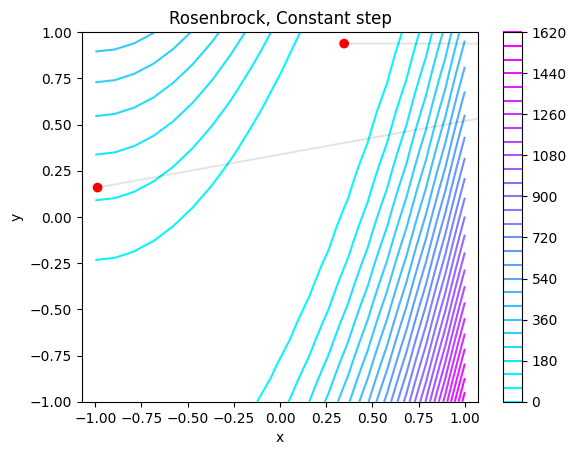

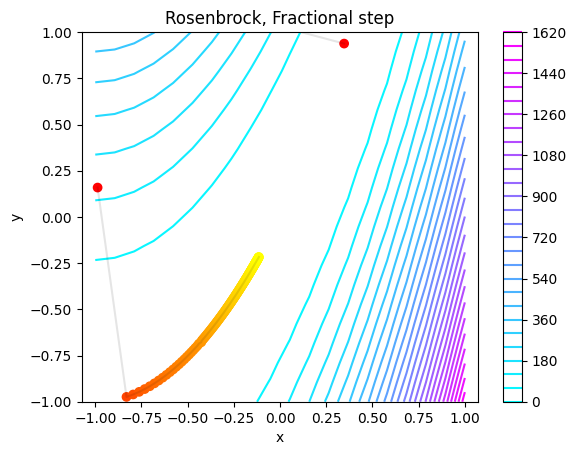

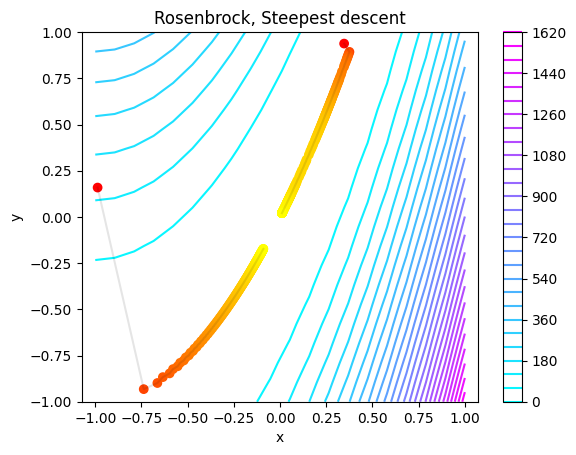

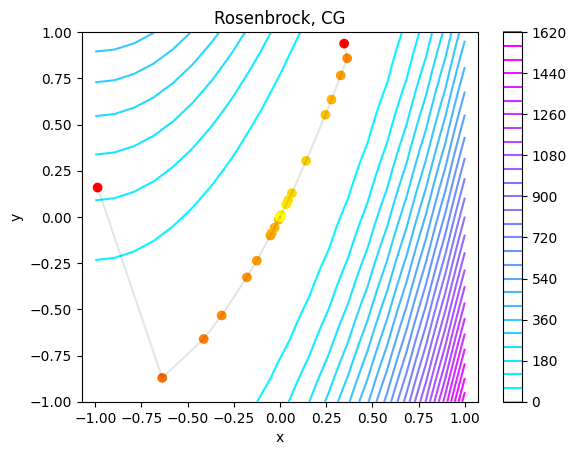

eps  Constant step (accuracy)  Constant step (iters)  \
0   1.000000e-01              16811.208079                   1000   
1   3.359818e-02              16811.208079                   1000   
2   1.128838e-02              16811.208079                   1000   
3   3.792690e-03              16811.208079                   1000   
4   1.274275e-03              16811.208079                   1000   
5   4.281332e-04              16811.208079                   1000   
6   1.438450e-04              16811.208079                   1000   
7   4.832930e-05              16811.208079                   1000   
8   1.623777e-05              16811.208079                   1000   
9   5.455595e-06              16811.208079                   1000   
10  1.832981e-06              16811.208079                   1000   
11  6.158482e-07              16811.208079                   1000   
12  2.069138e-07              16811.208079                   1000   
13  6.951928e-08              16811.208079                   1000   
14  2.335721e-08              16811.208079                   1000   
15  7.847600e-09              16811.208079                   1000   
16  2.636651e-09              16811.208079                   1000   
17  8.858668e-10              16811.208079                   1000   
18  2.976351e-10              16811.208079                   1000   
19  1.000000e-10              16811.208079                   1000   

    Constant step (calls)  Constant step (grads)  Fractional step (accuracy)  \
0                       0                   1000                    1.371241   
1                       0                   1000                    1.371241   
2                       0                   1000                    1.371241   
3                       0                   1000                    1.371241   
4                       0                   1000                    1.371241   
5                       0                   1000                    1.371241   
6                       0                   1000                    1.371241   
7                       0                   1000                    1.371241   
8                       0                   1000                    1.371241   
9                       0                   1000                    1.371241   
10                      0                   1000                    1.371241   
11                      0                   1000                    1.371241   
12                      0                   1000                    1.371241   
13                      0                   1000                    1.371241   
14                      0                   1000                    1.371241   
15                      0                   1000                    1.371241   
16                      0                   1000                    1.371241   
17                      0                   1000                    1.371241   
18                      0                   1000                    1.371241   
19                      0                   1000                    1.371241   

    Fractional step (iters)  Fractional step (calls)  Fractional step (grads)  \
0                      1000                     2000                     1000   
1                      1000                     2000                     1000   
2                      1000                     2000                     1000   
3                      1000                     2000                     1000   
4                      1000                     2000                     1000   
5                      1000                     2000                     1000   
6                      1000                     2000                     1000   
7                      1000                     2000                     1000   
8                      1000                     2000                     1000   
9                      1000                     2000                    

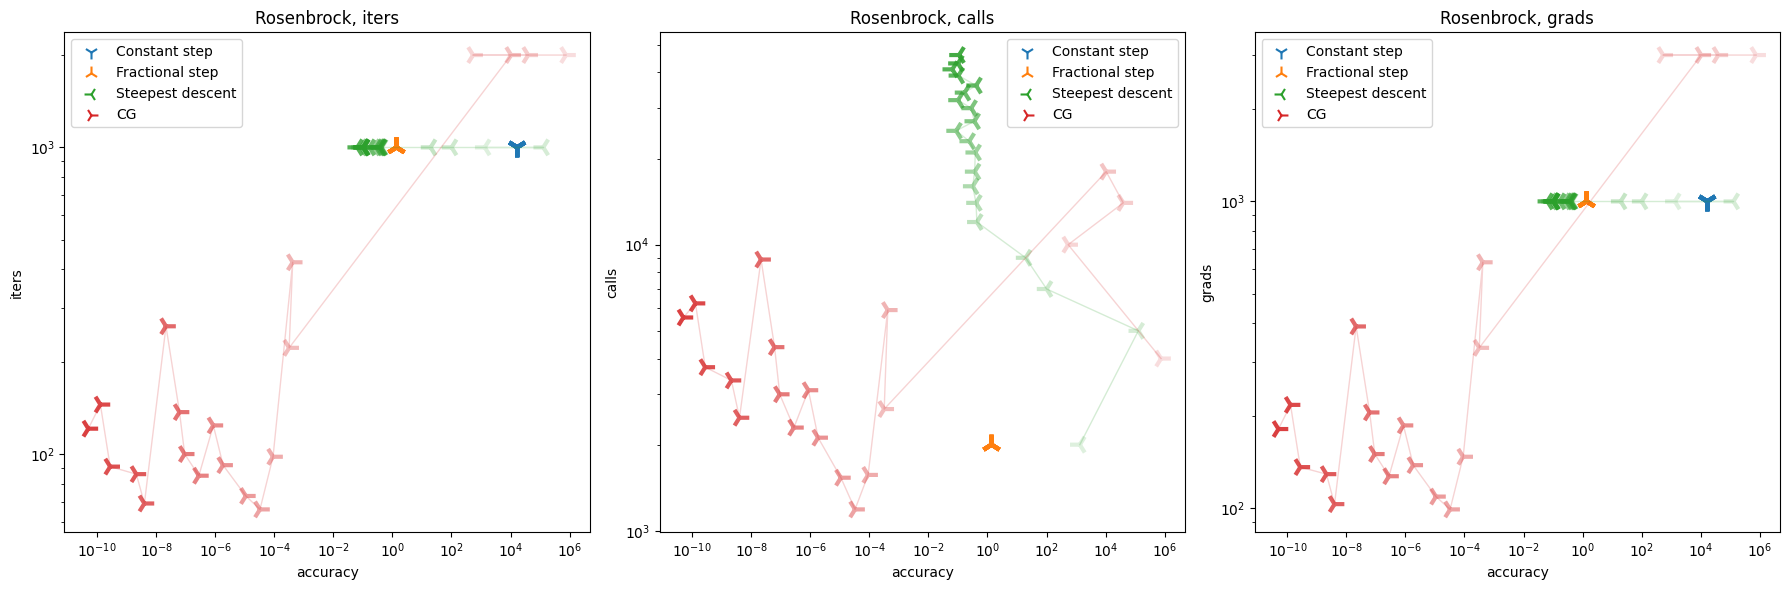

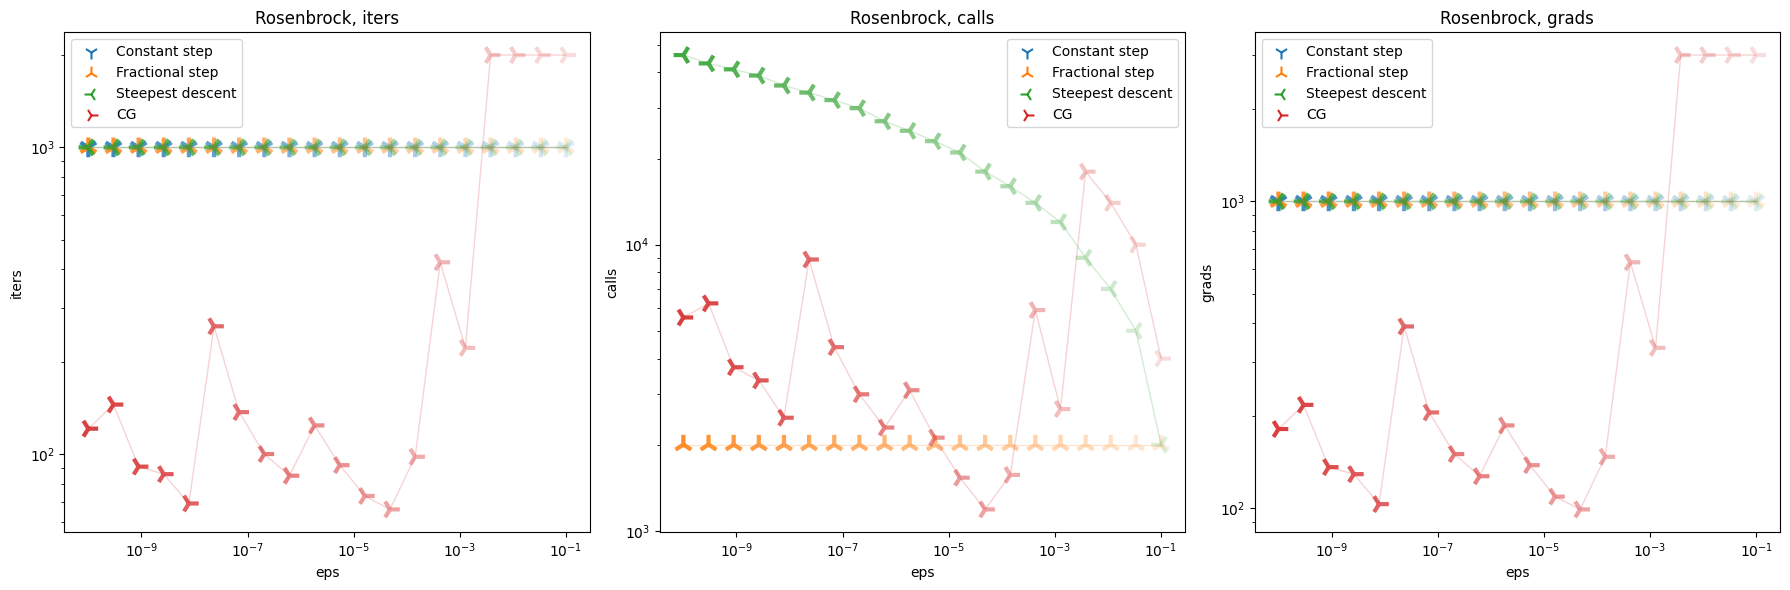

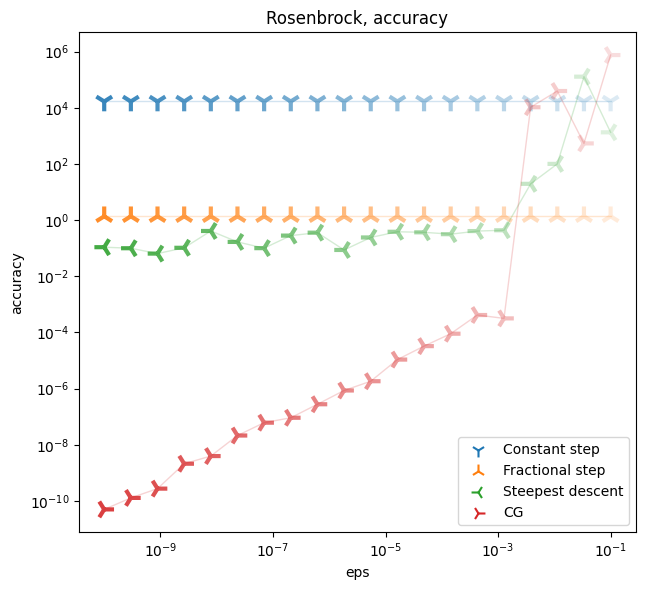

In [364]:
# just like the previous task, but with contour:
# a, b
functions = [
    (f_c, "Rosenbrock"),
]
methods = [
    (gd_constant_step, "Constant step"),
    (gd_fractional_step, "Fractional step"),
    (steepest_descent, "Steepest descent"),
    (conjugate_gradient, "CG"),
]

make_tables(functions,methods,plot_tables=True,contour=True)

#### 5
Implement a generator of quadratic functions of a given dimension and condition number. Investigate the dependence of the number of iterations that must be performed to achieve the selected accuracy, depending on these parameters. Consider this dependence for two gradient methods, one of which is (necessarily) the conjugate gradient method.

In [365]:
# creation of quadratic function 
# with given condition number
# A should be positive-definite and simmetric for all methods to work
# thus,
# let A = (B.T + B)/2 (to be simmetric) 
# Since it is known that G.T @ G is a positive definite matrix 
# (if G is invertible), 
# let B = G.T @ G
# 
# To generate arbitrary invertable matrix G, 
# it is enough to make a orthogonal transform of a diagonal matrix. 
# 
# To generate an arbitrary orthogonal transformation, 
# QR decomposition of a real random matrix C can be used.

In [366]:
def generator(mu: float, n: int) -> Callable[[np.ndarray], float]:
    assert mu >= 1
    # c = 0 if mu > 1 else mu / 100
    if n < 1:
        return None
    if n == 1:
        return lambda x: mu * x
    w = np.sqrt(mu)
    D = np.diag([w] + list(np.random.random(n - 2) * (w - 1) + 1) + [1 if w > 1 else w])
    C = np.random.random((n, n))
    Q, R = np.linalg.qr(C)
    G = Q.T @ D @ Q
    B = G.T @ G
    A = (B.T + B)/2
    # print(np.linalg.cond(A), mu, w)
    # print(A, D)
    if w >= 1:
        assert np.isclose(np.linalg.cond(A), mu)
    return lambda x: x.T @ A @ x


def test_generator():
    generator(1, 1)
    generator(2, 2)
    generator(3, 2)
    generator(4, 2)
    generator(4, 4)
    generator(1, 2)


test_generator()

In [367]:
methods = [
    (gd_constant_step, "Constant step"),
    (conjugate_gradient, "CG"),
]


def investigate_iter_vs_accuracy(mus:list[float],methods:list[tuple[Callable,str]], contour:bool=False, plot_table:bool = False,plot_illustrations=False):
    num_of_random_points = 5
    radius = 1
    n_countour_points = 20
    levels = 30
    functions = [(generator(mu,2),r"$\mu = "+str(mu)+'$') for mu in mus]
    eps = 1e-7
    xlim = [-1, 1]
    ylim = [-1, 1]
    random_points = [
        np.array(
            [
                np.cos(random_alpha * 2*np.pi) * radius + (xlim[1] + xlim[0]) / 2,
                np.sin(random_alpha * 2*np.pi) * radius + (ylim[1] + ylim[0]) / 2,
            ]
        )
        for random_alpha in np.random.random(num_of_random_points)
    ]

    data = dict()
    data["mus"] = mus
    for f, f_name in functions:
        if plot_illustrations:
            print()
            display(Markdown(f_name))
            plt.figure(figsize=(6*len(methods),6))
        for method_id,(method, method_name) in enumerate(methods):
            def plot_contours():
                plt.title(f_name+', '+method_name)
                plt.xlabel("x")
                plt.ylabel("y")
                xl = np.linspace(xlim[0], xlim[1], n_countour_points)
                yl = np.linspace(ylim[0], ylim[1], n_countour_points)
                x, y = np.meshgrid(xl, yl)
                z = 0 * x * y
                for qx, xp in enumerate(xl):
                    for qy, yp in enumerate(yl):
                        p = np.array([xp, yp])
                        # print(p)
                        z[qy, qx] = f(p)
                # plt.grid()
                plt.axis("equal")
                if contour:
                    plt.contour(x, y, z, levels=levels,cmap='cool')
                else:
                    plt.contourf(x, y, z, levels=levels,cmap='cool')
                plt.colorbar()

            if plot_illustrations:
                plt.subplot(1,len(methods),method_id+1)
                plot_contours()
            acc_multipoint, iters_multipoint, calls_multipoint, grad_multipoint = (
                [],
                [],
                [],
                [],
            )
            for point in random_points:
                # solve
                p = point.copy()
                result, iters, calls, grad_calls, trajectory = method(
                    f, p, eps=eps, info=True
                )
                if plot_illustrations:
                    trajectory = np.array(trajectory)
                    x, y = trajectory.T[0], trajectory.T[1]
                    # print(x[0],y[0])
                    x, y = x[::5], y[::5]
                    c = [
                        (q / len(x))**0.25
                        for q in range(len(x))
                    ]
                    plt.plot(x, y, color="black", alpha=0.1)
                    plt.scatter(x, y, c=c,cmap='autumn')
                acc_multipoint.append(
                    np.linalg.norm(result - np.zeros_like(result))
                )
                iters_multipoint.append(iters)
                calls_multipoint.append(calls)
                grad_multipoint.append(grad_calls)
            acc_total=np.mean(acc_multipoint)
            iters_total=int(np.mean(iters_multipoint))
            calls_total=int(np.mean(calls_multipoint))
            grad_total=int(np.mean(grad_multipoint))
            if plot_illustrations:
                plt.xlim(xlim)
                plt.ylim(ylim)
            data.setdefault(method_name + " (accuracy)",[]).append(acc_total)
            data.setdefault(method_name + " (iters)",[]).append(iters_total)
            data.setdefault(method_name + " (calls)",[]).append(calls_total)
            data.setdefault(method_name + " (grads)",[]).append(grad_total)
        if plot_illustrations:
            plt.show()
    data = pd.DataFrame(data)
    display(data)
    if plot_table:
        # accuracy
        plt.figure(figsize=(18,6))
        for plot_idx,plot_type in enumerate(['iters','calls','grads']):
            plt.subplot(1,3,plot_idx+1)
            plt.title(plot_type)
            for method_id,(method, method_name) in enumerate(methods):
                alpha = [(0.2+idx/len(data[method_name + f" ({plot_type})"]))/1.3 for idx, d in enumerate(data[method_name + f" ({plot_type})"])]
                c,=plt.plot([],[])
                c=c.get_color()
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    plt.scatter([],[],label=method_name,marker=str(method_id+1),s=100,c=c)
                    plt.scatter(data[method_name + " (accuracy)"],data[method_name + f" ({plot_type})"],marker=str(method_id+1),alpha=alpha,s=200, c=c,lw=3)
                    plt.plot(data[method_name + " (accuracy)"],data[method_name + f" ({plot_type})"],alpha=0.2,c=c,lw=1)
                    plt.xscale('log')
                    plt.yscale('log')
            plt.xlabel('accuracy')
            plt.ylabel(plot_type)
            plt.legend()
        plt.tight_layout()
        plt.show()
        # mus
        plt.figure(figsize=(18,6))
        for plot_idx,plot_type in enumerate(['iters','calls','grads']):
            plt.subplot(1,3,plot_idx+1)
            plt.title(plot_type)
            for method_id,(method, method_name) in enumerate(methods):
                alpha = [(0.2+idx/len(data[method_name + f" ({plot_type})"]))/1.3 for idx, d in enumerate(data[method_name + f" ({plot_type})"])]
                c,=plt.plot([],[])
                c=c.get_color()
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    plt.scatter([],[],label=method_name,marker=str(method_id+1),s=100,c=c)
                    plt.scatter(data["mus"],data[method_name + f" ({plot_type})"],marker=str(method_id+1),alpha=alpha,s=200, c=c,lw=3)
                    plt.plot(data["mus"],data[method_name + f" ({plot_type})"],alpha=0.2,c=c,lw=1)
                    plt.xscale('log')
                    plt.yscale('log')
            plt.xlabel('mus')
            plt.ylabel(plot_type)
            plt.legend()
        plt.tight_layout()
        plt.show()
        # mus vs accuracy
        plt.figure(figsize=(18,6))
        for plot_idx,plot_type in enumerate(['accuracy']):
            plt.subplot(1,3,plot_idx+1)
            plt.title(plot_type)
            for method_id,(method, method_name) in enumerate(methods):
                alpha = [(0.2+idx/len(data[method_name + f" ({plot_type})"]))/1.3 for idx, d in enumerate(data[method_name + f" ({plot_type})"])]
                c,=plt.plot([],[])
                c=c.get_color()
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    plt.scatter([],[],label=method_name,marker=str(method_id+1),s=100,c=c)
                    plt.scatter(data["mus"],data[method_name + f" ({plot_type})"],marker=str(method_id+1),alpha=alpha,s=200, c=c,lw=3)
                    plt.plot(data["mus"],data[method_name + f" ({plot_type})"],alpha=0.2,c=c,lw=1)
                    plt.xscale('log')
                    plt.yscale('log')
            plt.xlabel('mus')
            plt.ylabel(plot_type)
            plt.legend()
        plt.tight_layout()
        plt.show()

$\mu = 1.0$

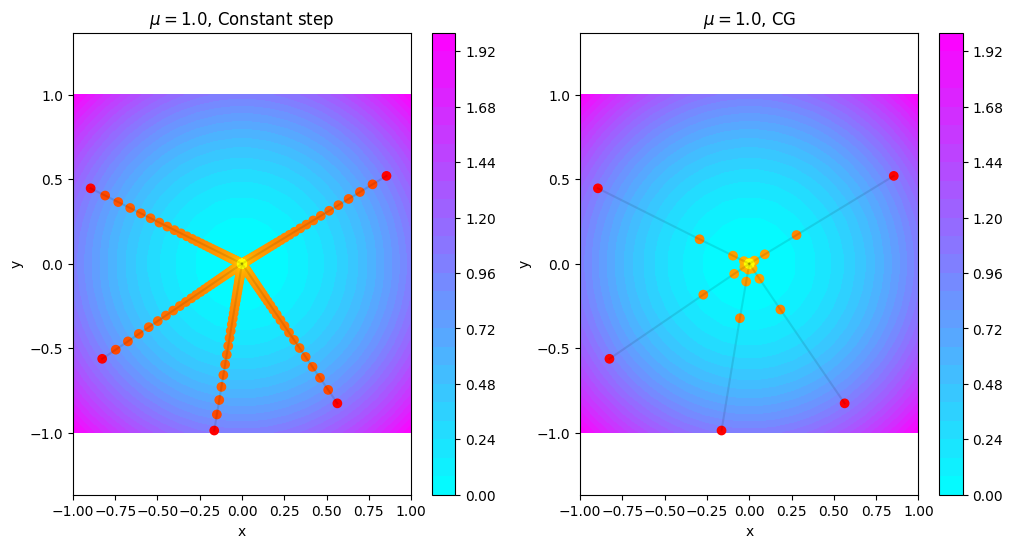

$\mu = 2.154434690031884$

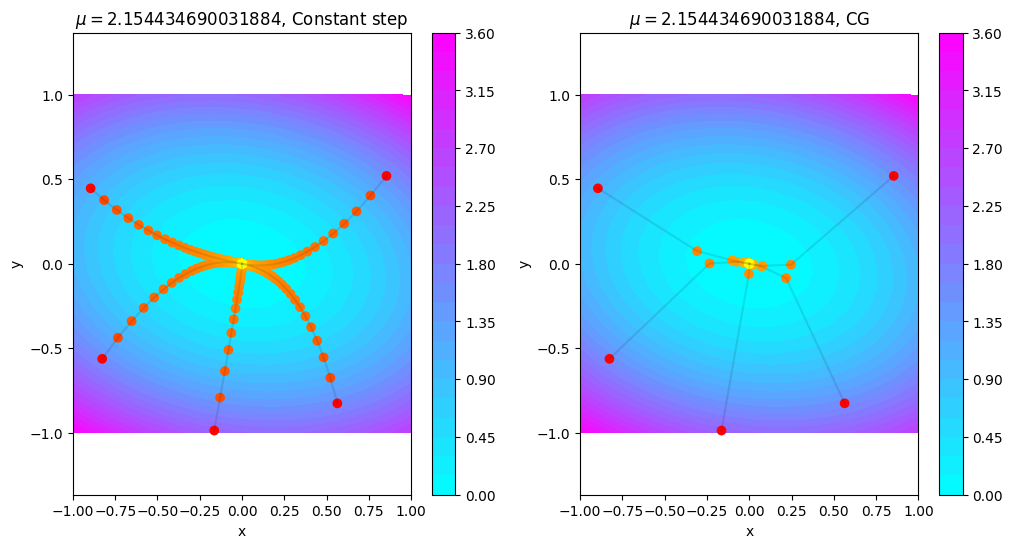

$\mu = 4.641588833612778$

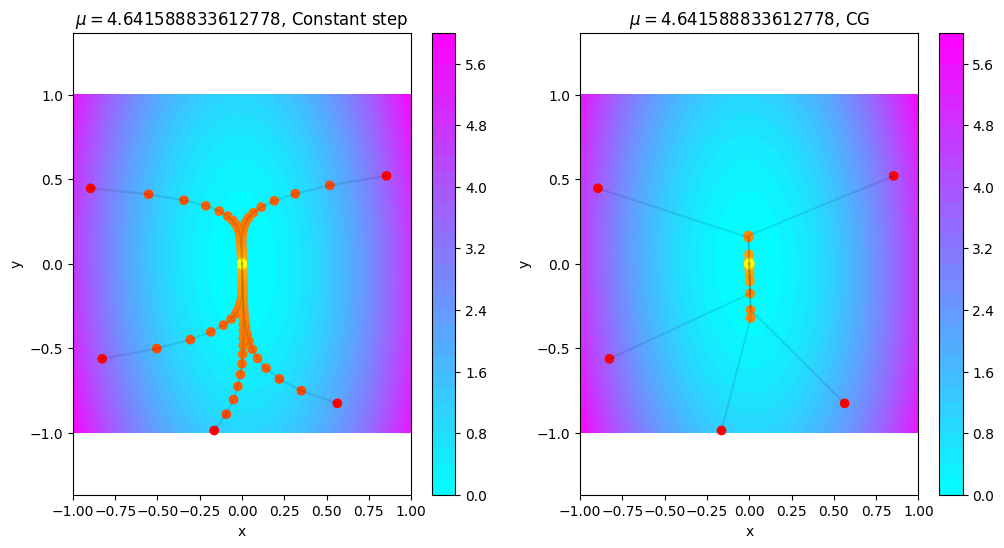

$\mu = 10.0$

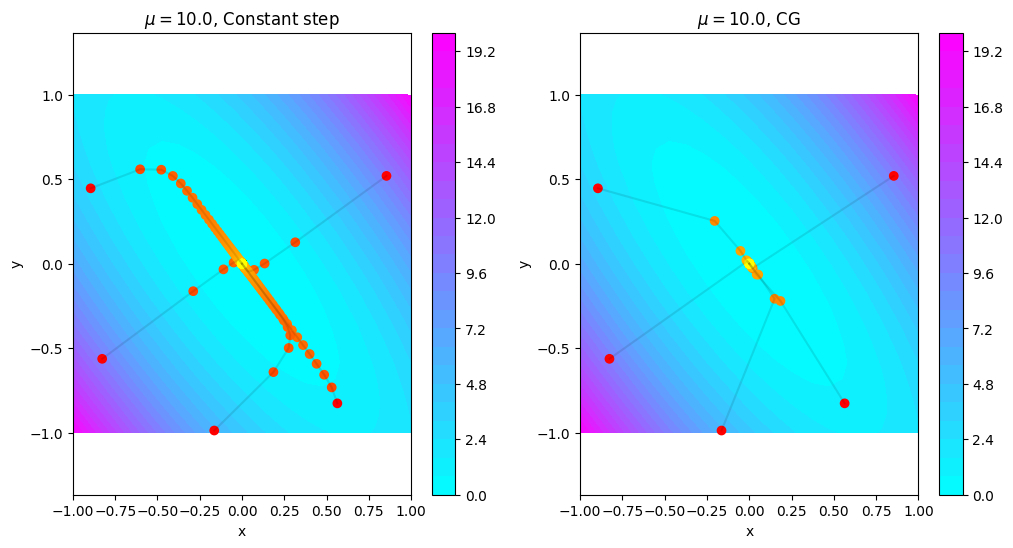

$\mu = 21.544346900318832$

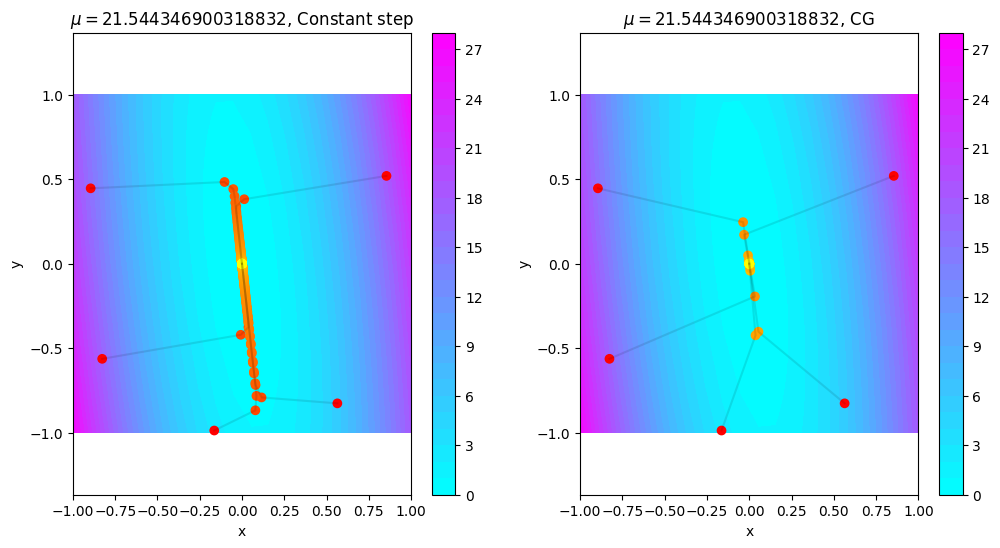

$\mu = 46.41588833612777$

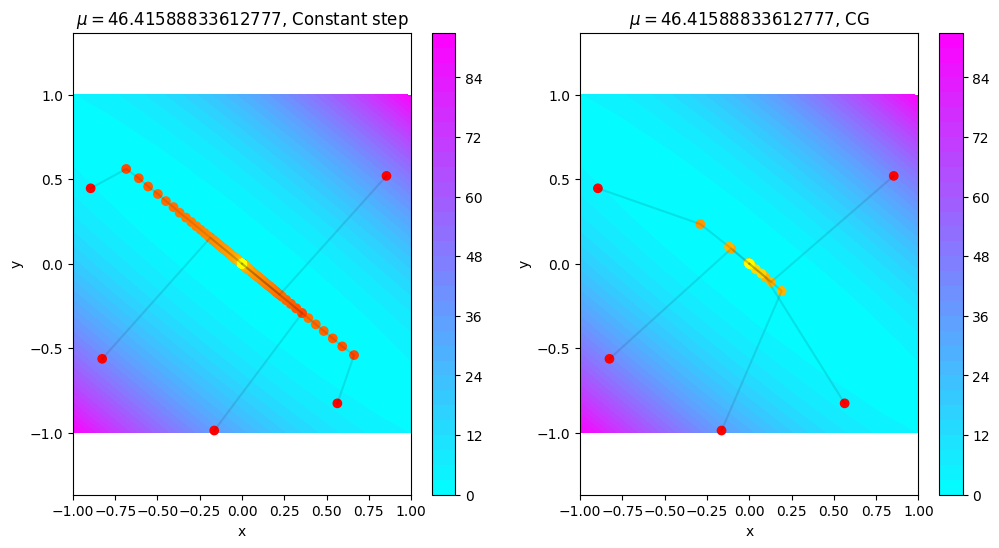

$\mu = 100.0$

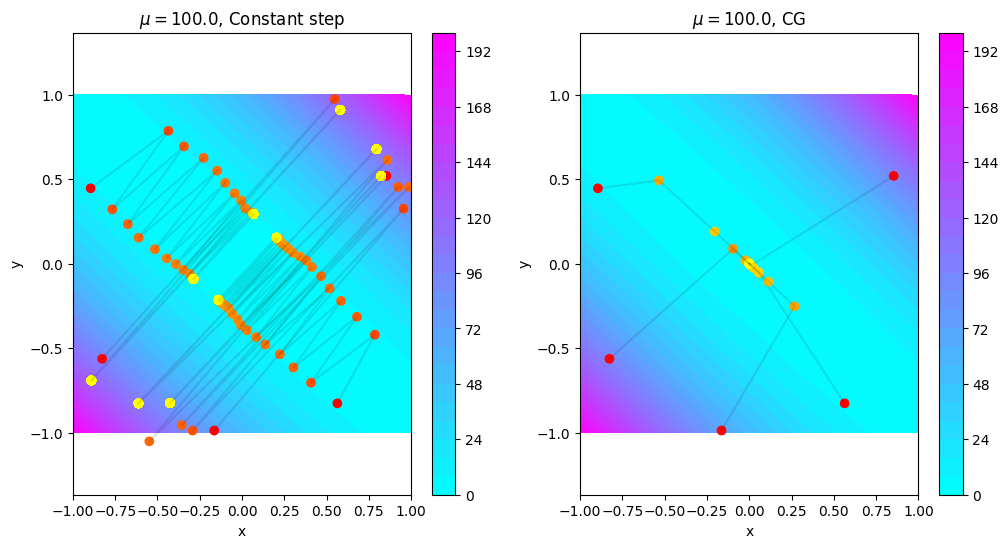

$\mu = 215.44346900318823$

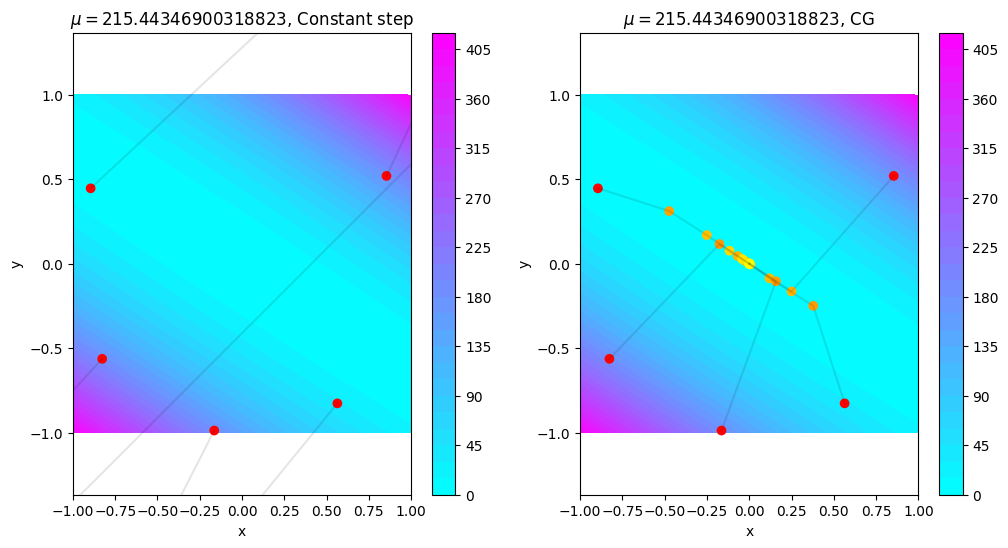

$\mu = 464.15888336127773$

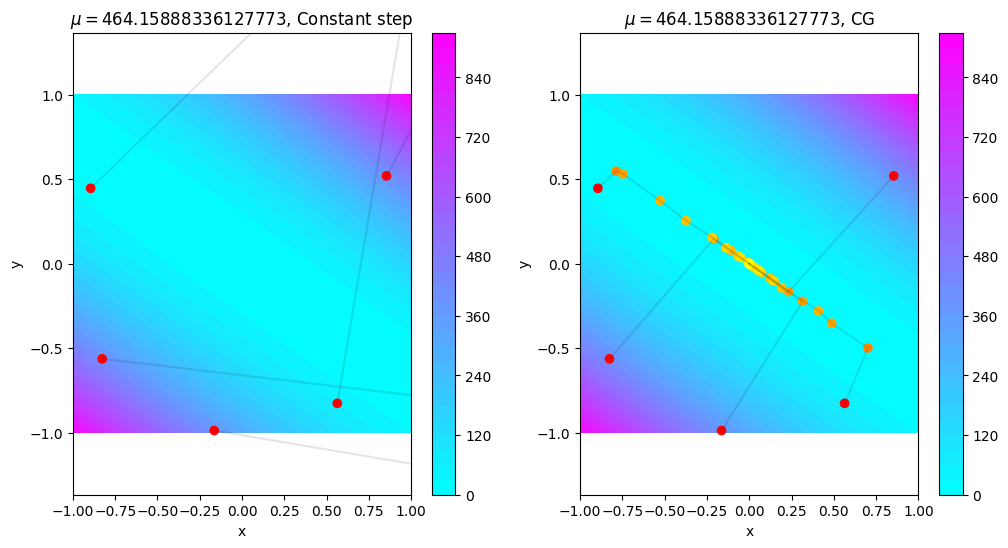

$\mu = 1000.0$

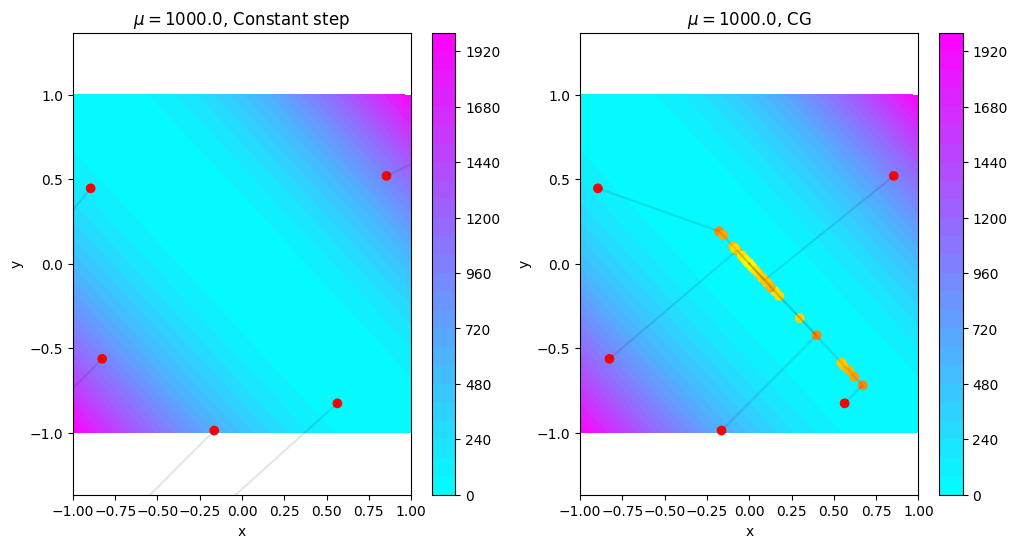

mus  Constant step (accuracy)  Constant step (iters)  \
0     1.000000              9.961908e-08                    798   
1     2.154435              9.921531e-08                    750   
2     4.641589              9.884831e-08                    776   
3    10.000000              9.898126e-08                    740   
4    21.544347              9.936344e-08                    774   
5    46.415888              9.893984e-08                    766   
6   100.000000              7.369400e-01                   1000   
7   215.443469              1.509064e+02                   1000   
8   464.158883              2.449684e+02                   1000   
9  1000.000000              1.943260e+02                   1000   

   Constant step (calls)  Constant step (grads)  CG (accuracy)  CG (iters)  \
0                      0                    798   8.415751e-08          73   
1                      0                    750   8.951858e-08          68   
2                      0                    776   8.788901e-08          70   
3                      0                    740   8.670932e-08          61   
4                      0                    774   7.355675e-08          42   
5                      0                    766   6.164378e-08          29   
6                      0                   1000   4.104075e-08          30   
7                      0                   1000   6.186672e-08          33   
8                      0                   1000   4.114383e-08          44   
9                      0                   1000   2.682239e-08          52   

   CG (calls)  CG (grads)  
0        2263         110  
1        2126         103  
2        2194         106  
3        1891          91  
4        1320          64  
5         905          43  
6         954          46  
7        1023          49  
8        1364          66  
9        1636          79

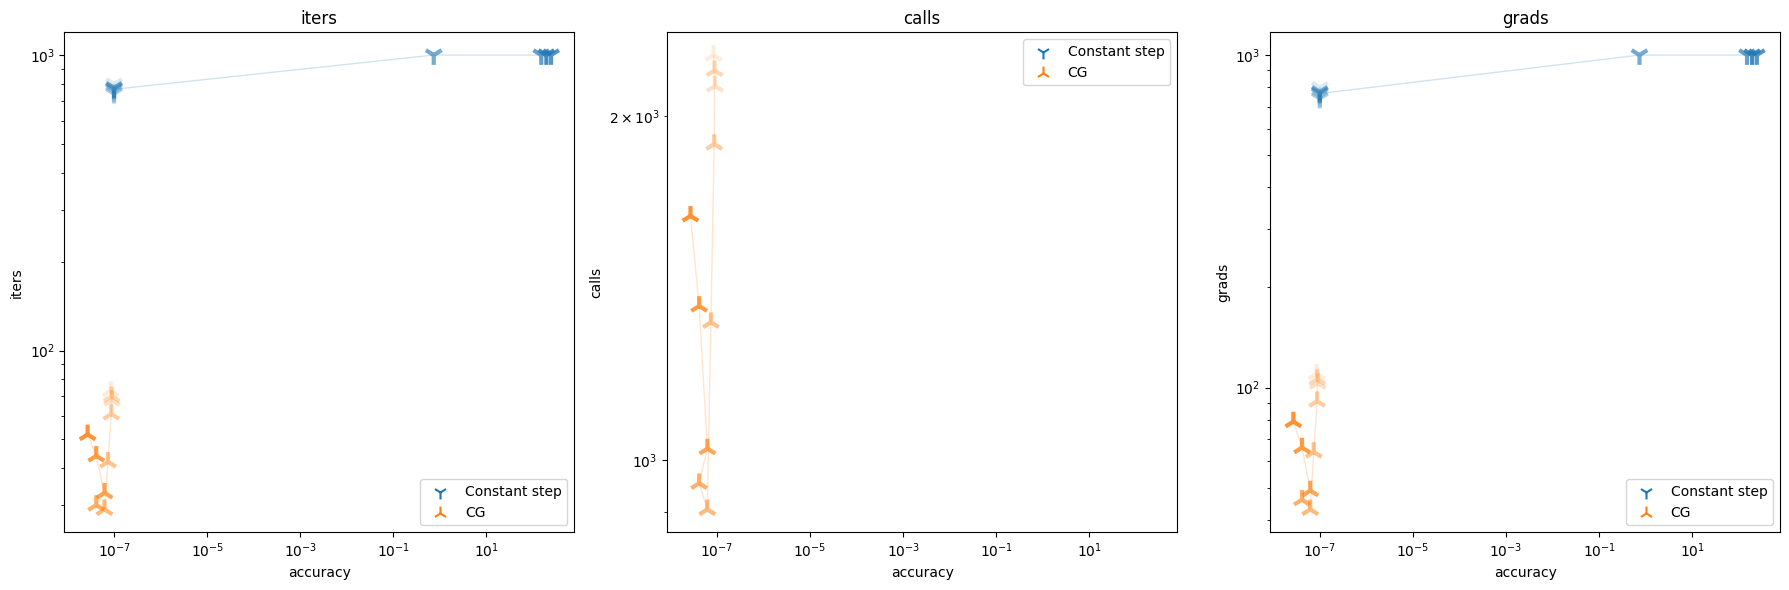

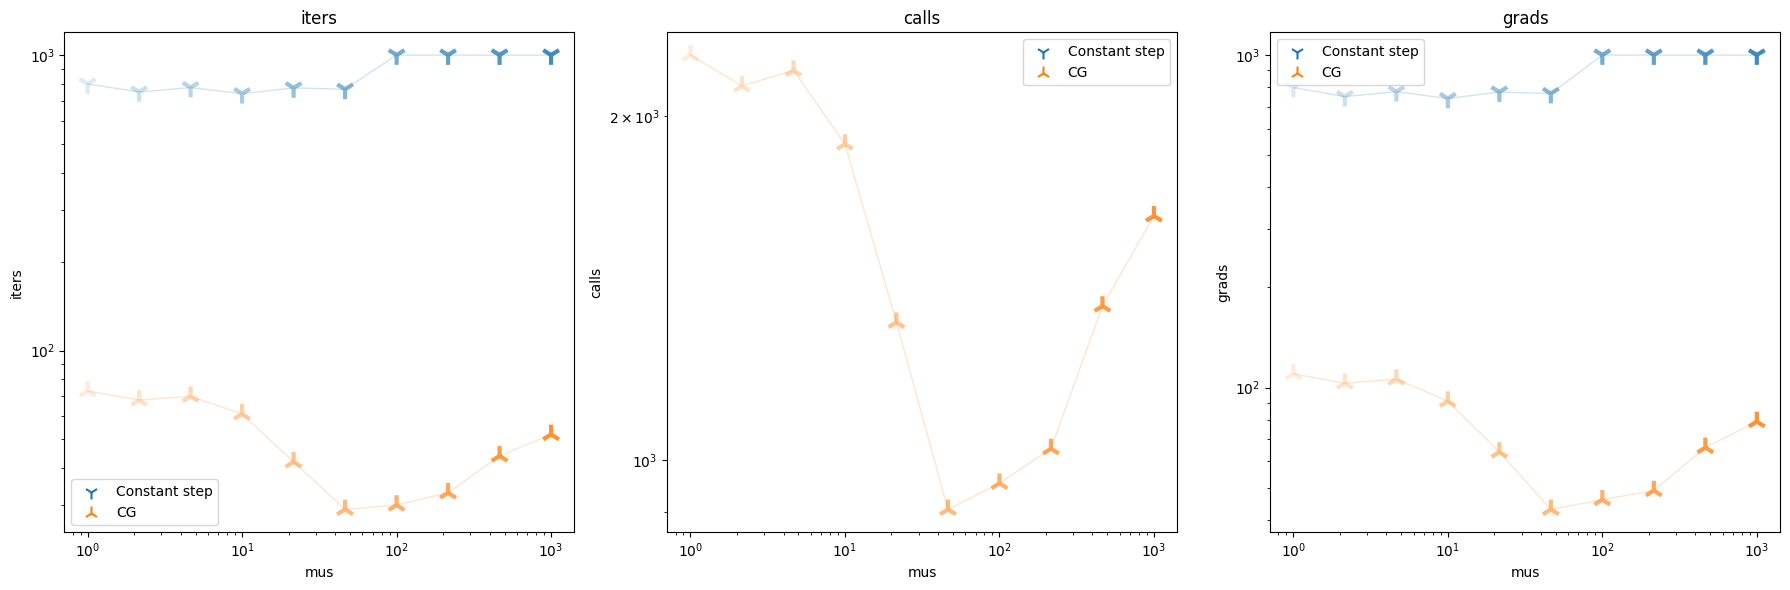

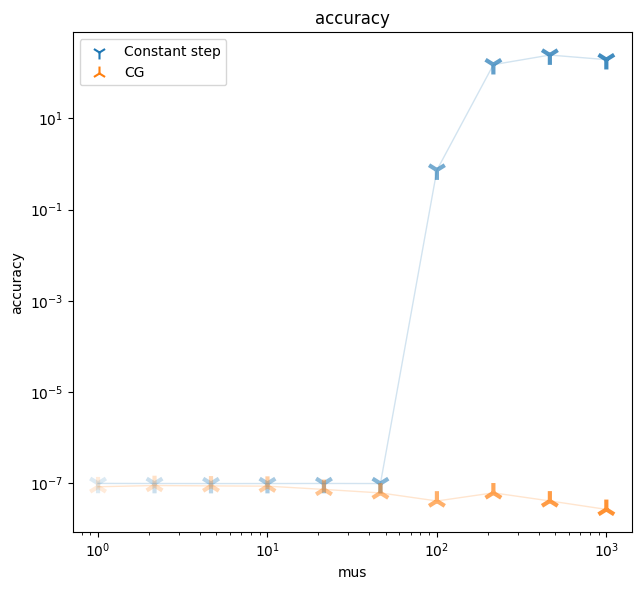

In [368]:
mus = np.logspace(0,3,10)
investigate_iter_vs_accuracy(mus,methods,plot_table=True, plot_illustrations=True)

mus  Constant step (accuracy)  Constant step (iters)  \
0    1.000000              9.961943e-08                    798   
1    1.162833              9.865263e-08                    769   
2    1.352180              9.906422e-08                    746   
3    1.572359              9.863629e-08                    750   
4    1.828391              9.882077e-08                    728   
5    2.126112              9.879228e-08                    766   
6    2.472313              9.920457e-08                    776   
7    2.874886              9.911368e-08                    767   
8    3.343012              9.889336e-08                    778   
9    3.887364              9.914831e-08                    762   
10   4.520354              9.892359e-08                    775   
11   5.256415              9.911434e-08                    781   
12   6.112331              9.897821e-08                    658   
13   7.107619              9.870808e-08                    776   
14   8.264972              9.923906e-08                    773   
15   9.610780              9.951250e-08                    751   
16  11.175729              9.870832e-08                    738   
17  12.995503              9.901367e-08                    747   
18  15.111596              9.908147e-08                    785   
19  17.572259              9.913305e-08                    769   
20  20.433597              9.879947e-08                    730   
21  23.760855              9.926127e-08                    670   
22  27.629900              9.922106e-08                    739   
23  32.128951              9.913955e-08                    744   
24  37.360596              9.841779e-08                    729   
25  43.444123              9.853061e-08                    780   
26  50.518247              9.885776e-08                    784   
27  58.744271              9.882639e-08                    685   
28  68.309760              9.908637e-08                    773   
29  79.432823              9.834976e-08                    776   

    Constant step (calls)  Constant step (grads)  CG (accuracy)  CG (iters)  \
0                       0                    798   8.448892e-08          73   
1                       0                    769   9.143914e-08          70   
2                       0                    746   8.628037e-08          68   
3                       0                    750   8.899896e-08          68   
4                       0                    728   8.934180e-08          66   
5                       0                    766   8.915229e-08          69   
6                       0                    776   8.848620e-08          70   
7                       0                    767   9.296199e-08          69   
8                       0                    778   9.117489e-08          70   
9                       0                    762   9.130974e-08          69   
10                      0                    775   9.009421e-08          70   
11                      0                    781   8.672567e-08          71   
12                      0                    658   8.870695e-08          61   
13                      0                    776   9.362558e-08          70   
14                      0                    773   8.706238e-08          71   
15                      0                    751   9.043261e-08          64   
16                      0                    738   8.488821e-08          55   
17                      0                    747   8.606605e-08          50   
18                      0                    785   8.064676e-08          50   
19                      0                    769   7.364595e-08          49   
20                      0                    730   9.100773e-08          46   
21                      0                    670   8.753411e-08          39   
22                      0                    739   8.102731e-08          33   
23                      0                    744   5.604824e-08    

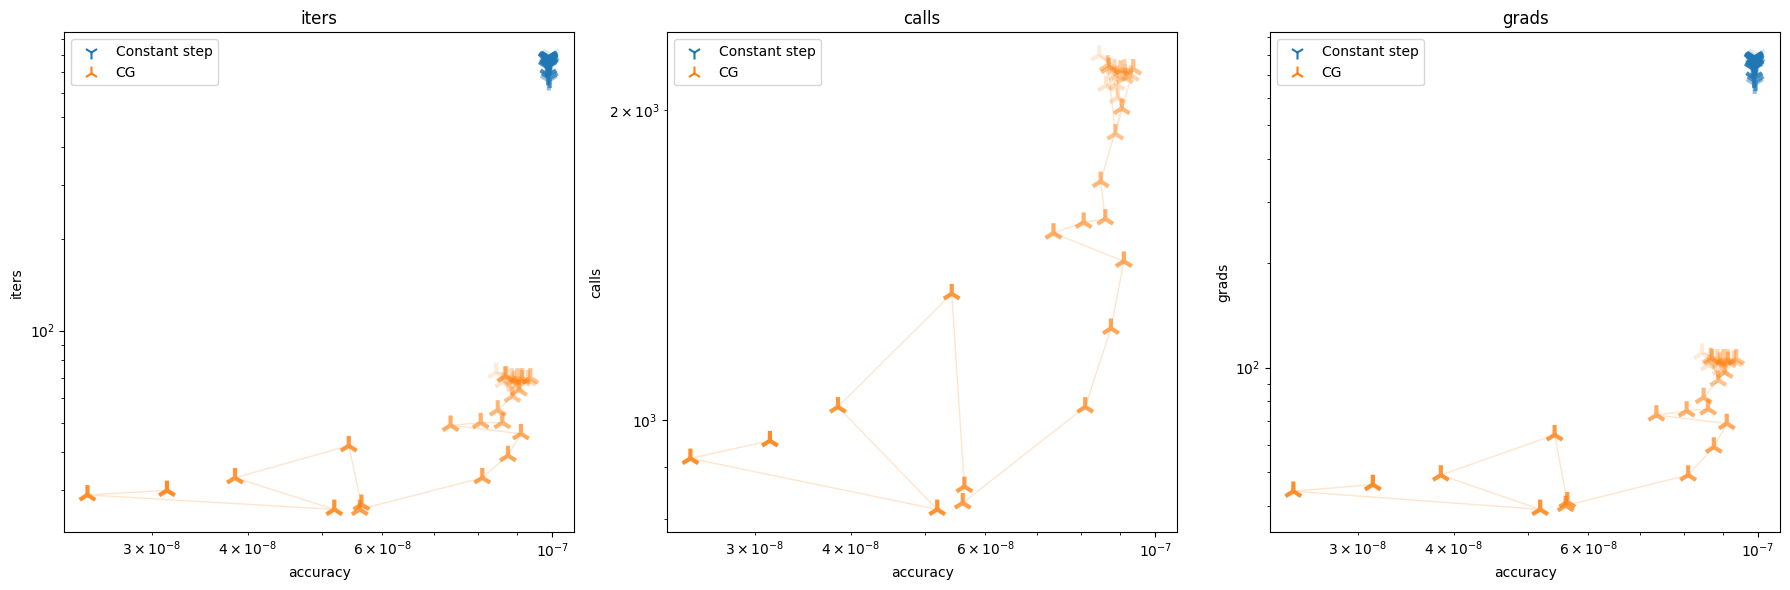

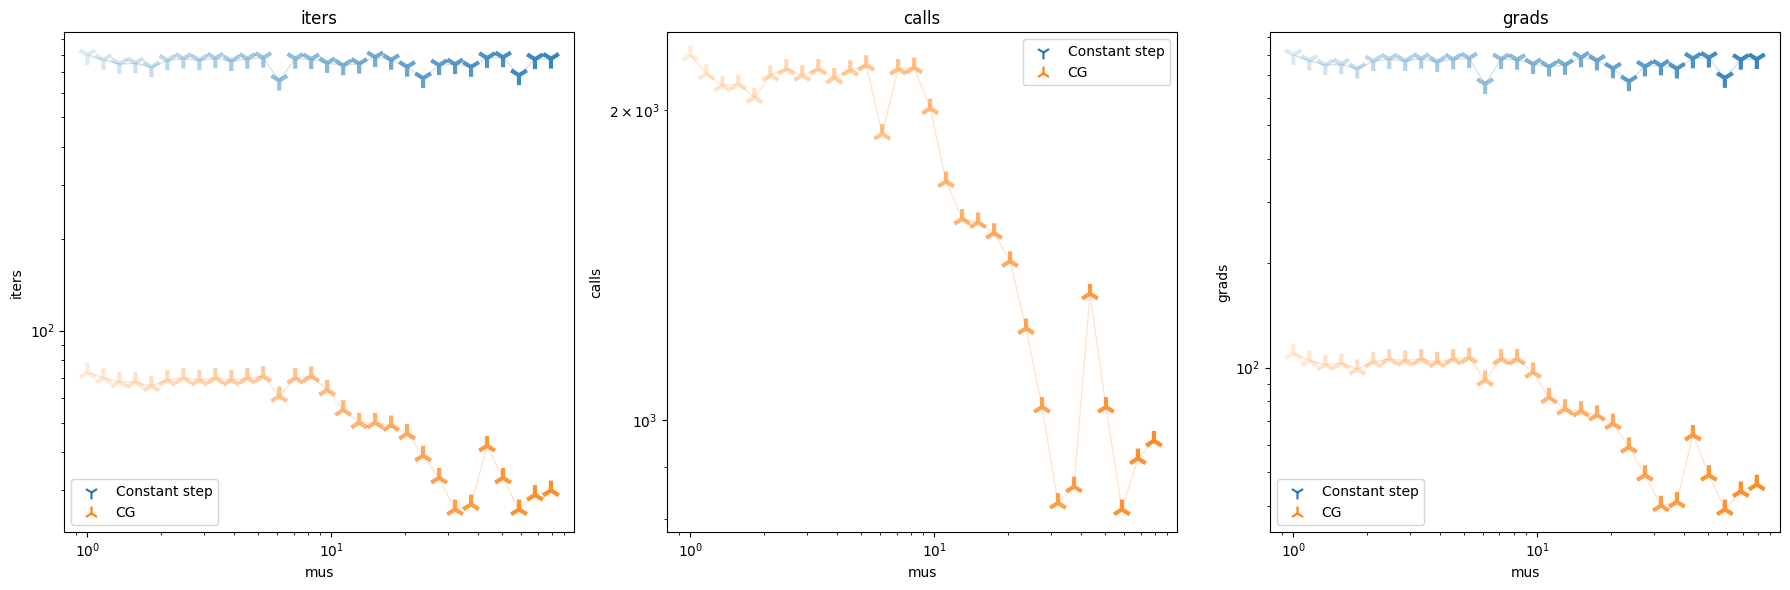

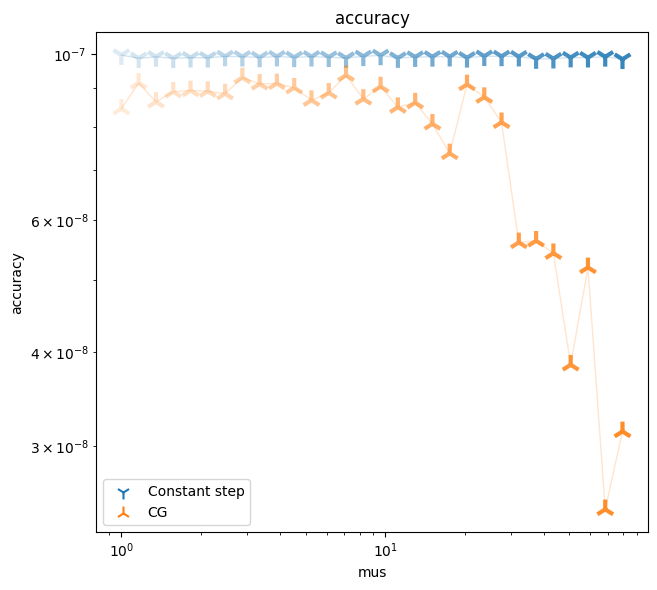

In [369]:
mus = np.logspace(0,1.9,30)
investigate_iter_vs_accuracy(mus,methods,plot_table=True, plot_illustrations=False)